In [ ]:
# SIGLEC6, CD33, CD70 
# double check the genotype when the bam file is available. 

# package import

In [3]:
library(DESeq2)
library(data.table)
library(dplyr)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(EnsDb.Hsapiens.v75)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(IRdisplay)
library(ChIPpeakAnno)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(kableExtra)
library(tidyverse)
library(readxl)
library(umap)
library(ggrepel)
library(msigdbr)
library(fgsea)
library(ggvenn)
library(data.table)
library(edgeR)
library(ComplexHeatmap)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene


In [4]:
source('~/script/utils.r')

In [5]:
setwd('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_BisiMiao/')

In [6]:
geneID = fread('~/workspace/human_to_mouse.csv')
setnames(geneID, 1, 'ensg')
setnames(geneID, 2, 'symbol')
setkey(geneID, 'ensg')
head(geneID)


ensg            symbol Mouse gene name Mouse gene stable ID
1 ENSG00000000003 TSPAN6 Tspan6          ENSMUSG00000067377  
2 ENSG00000000005 TNMD   Tnmd            ENSMUSG00000031250  
3 ENSG00000000419 DPM1   Dpm1            ENSMUSG00000078919  
4 ENSG00000000457 SCYL3  Scyl3           ENSMUSG00000026584  
5 ENSG00000000460 FIRRM  Firrm           ENSMUSG00000041406  
6 ENSG00000000938 FGR    Fgr             ENSMUSG00000028874  
  Mouse homology type Mouse orthology confidence [0 low, 1 high]
1 ortholog_one2one    1                                         
2 ortholog_one2one    1                                         
3 ortholog_one2one    1                                         
4 ortholog_one2one    1                                         
5 ortholog_one2one    1                                         
6 ortholog_one2one    1                                         
  Mouse Gene-order conservation score
1 100                                
2 100                                
3 100                                
4 100                                
5   0                                
6 100

# data import

## import expression data of HTSeq counts

In [7]:
base_dir = '/research_jude/rgs01_jude/groups/jxugrp/projects/klco_xu/common/pAML_n887/'
fname = paste0(base_dir, 'pAML887_5CD34_RNAseq_HTseq_rawCount_jma_20MAR24.txt')
mtx_orig = fread(fname)
mtx = setDF(mtx_orig[, 8:ncol(mtx_orig)], rownames = mtx_orig$Gene)


In [8]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_BisiMiao"

In [9]:
tail(mtx[1:3, 1:10])

SJCBF022_D SJCBF030_D SJCBF034_D SJAML007110_D1 SJAML007122_D1
5S_rRNA  0          1          0          0              0            
7SK      0          0          0          0              0            
A1BG    55         44         27         78             31            
        SJAML030118_D1 SJAML030324_D1 SJAML045742_D2 SJAML031259_D1
5S_rRNA 0              0               0             1             
7SK     0              0               0             0             
A1BG    6              2              30             0             
        SJAML031302_D2
5S_rRNA  0            
7SK      0            
A1BG    16

In [10]:
dim(mtx)

[1] 33572   892

In [12]:
saveRDS(mtx, file = 'data/nb_clin_AML_mtx.rds')


mtx = readRDS('data/nb_clin_AML_mtx.rds')


## import expression data of log2CPM

In [11]:
fname = paste0(base_dir, 'pAML887_5CD34_RNAseq_log2CPM_BC_jma_20MAR24.txt')
mtx_cpm_orig = fread(fname)
mtx_cpm = setDF(mtx_cpm_orig[, 8:ncol(mtx_cpm_orig)], rownames = mtx_cpm_orig$Gene)


In [27]:
head(mtx_cpm)
dim(mtx_cpm)


SJCBF000089_D2 SJCBF001018_D1 SJAML001408_D1 SJAML001409_D2
5S_rRNA  -5.8648288     -5.7454507     -4.4701751     -5.8636560    
7SK      -5.8685512     -5.7506589     -5.6919534     -5.8672138    
A1BG     -1.2559298      0.6384744     -0.1103343      0.6739167    
A1BG-AS1 -0.9459269      2.5301650     -0.3000682      3.0123156    
A1CF     -5.9000614     -5.9371082     -1.0272325     -5.8988662    
A2M       2.7352686     -3.3476473      0.6570276     -3.4597297    
         SJAML001414_D3 SJAML001417_D1 SJAML001427_D3 SJAML001428_D1
5S_rRNA  -5.876723      -5.9125722     -4.1308584     -3.6431302    
7SK      -5.882115      -5.9229971     -4.5588339     -5.8508565    
A1BG     -1.132836      -0.1316309      0.7515044      0.2885244    
A1BG-AS1  1.984697       2.1864106      3.8284315      2.7556449    
A1CF     -5.912183      -5.9487161     -3.3299313     -5.8842487    
A2M      -3.017287       0.1076485     -0.2166754     -1.3931116    
         SJAML001430_D2 SJAML001440_D2 ⋯ SJAML074193_D1 SJAML074194_D1
5S_rRNA  -5.8693776     -5.8561515     ⋯ -5.8811053     -5.9025842    
7SK      -5.8737386     -5.8586558     ⋯ -5.8871127     -5.9116070    
A1BG     -0.8111047     -0.1737765     ⋯  0.9869009     -2.6773666    
A1BG-AS1  1.9394286      3.1239857     ⋯  2.8109399      0.7783609    
A1CF     -5.9046970     -5.8912185     ⋯ -5.9166485     -5.9385375    
A2M       0.6587059     -3.0542717     ⋯ -2.5034942      1.2209381    
         SJAML074195_D1 SJAML074196_D1 SJAML074197_D2 SJAML062379_G1
5S_rRNA  -5.9089666     -5.9021860     -5.911575      -4.6742184    
7SK      -3.9796177     -5.9111529     -4.090048      -5.7613223    
A1BG     -0.9589207      0.9731203     -5.748205      -0.7661324    
A1BG-AS1  1.6277688      2.8753626     -3.127919       1.0941333    
A1CF     -5.9450418     -5.9381317      1.284733      -3.5990323    
A2M       2.9246673     -5.5233448      7.328654       4.4588763    
         SJAML062380_G1 SJAML062381_G1 SJAML062382_G1 SJAML062383_G1
5S_rRNA  -5.2386064     -5.14893454    -3.8359636     -5.509467871  
7SK      -5.7367723     -5.88743345    -5.5159716     -5.766731882  
A1BG     -1.5830535     -1.82196344    -2.1816248     -0.005870255  
A1BG-AS1  0.4924937      0.65353645     0.7740650      1.895687756  
A1CF     -2.9163957     -3.41310534    -3.6724409     -2.449084485  
A2M       0.7937466      0.04651036     0.3622641      1.599449931

[1] 32531   892

In [26]:
head(row_sd)

[1] 5.959370 5.935017 5.882808 5.856322 5.565954 5.274958

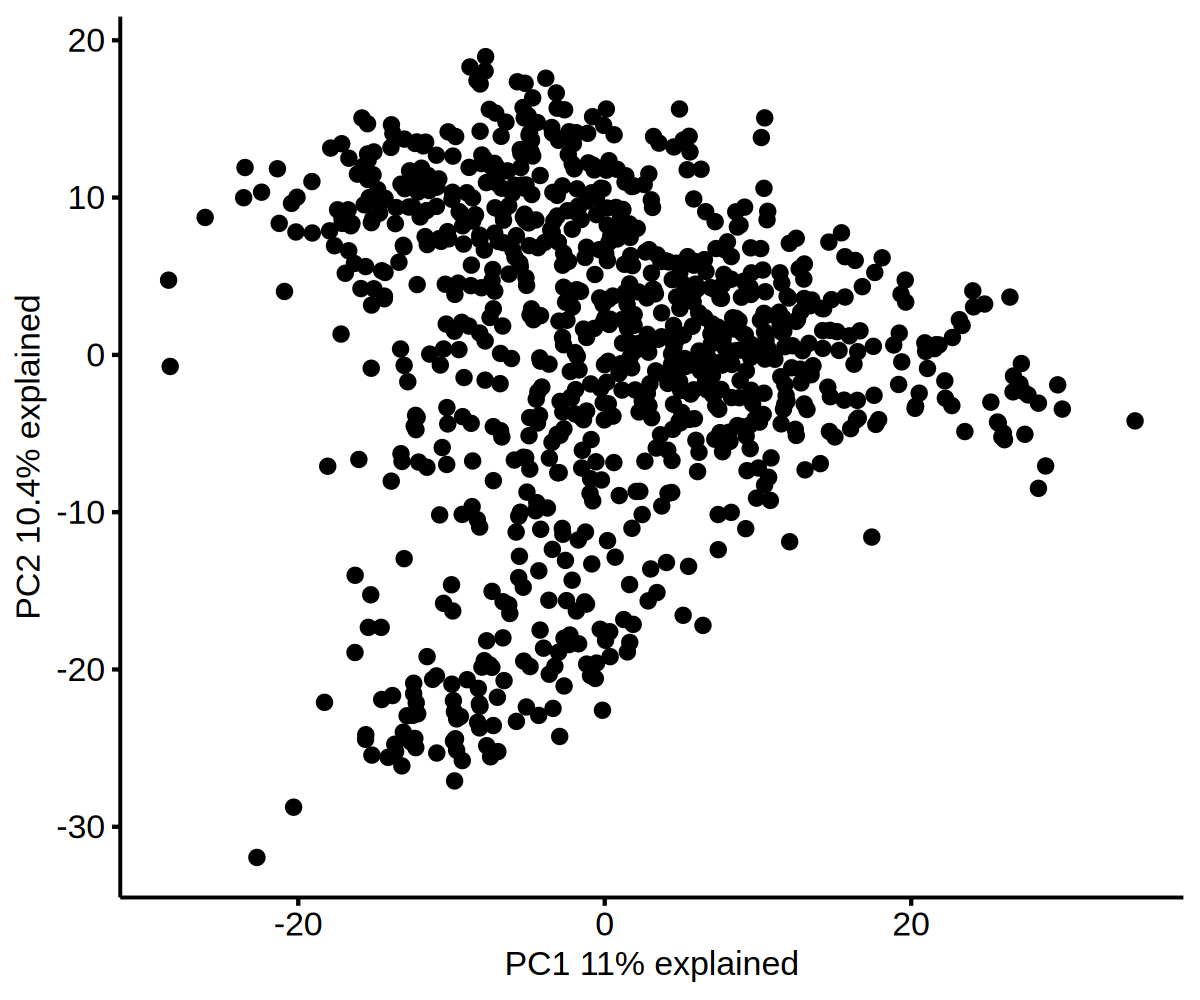

In [29]:
ntop = 1000
ex_df = as.matrix(mtx_cpm)
row_sd = rowSds(ex_df)
names(row_sd) = rownames(mtx_cpm)
row_sd = sort(row_sd, decreasing = T)
sel = names(row_sd[1:ntop])
mtx = ex_df[sel, ]

pc = prcomp(t(mtx), center = TRUE, scale = TRUE)
lblx = paste0('PC1 ', round(100 * pc$sdev[1]^2/sum(pc$sdev^2), 1), '% explained')
lbly = paste0('PC2 ', round(100 * pc$sdev[2]^2/sum(pc$sdev^2), 1), '% explained')
plotdat = as.data.table(pc$x, keep.rownames = T)
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
ggscatter(plotdat, x = 'PC1', y = 'PC2') + xlab(lblx) + ylab(lbly)


In [17]:
mtx_cpm_dt = as.data.table(mtx_cpm, keep.rownames = T)
setnames(mtx_cpm_dt, 1, 'geneName')
fwrite(mtx_cpm_dt, file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/share_data/pAML_887cases_5CD34_log2CPM.xls', sep = '\t')
head2(mtx_cpm_dt) 


geneName SJCBF000089_D2 SJCBF001018_D1 SJAML001408_D1 SJAML001409_D2
1 5S_rRNA  -5.864829      -5.7454507     -4.4701751     -5.8636560    
2 7SK      -5.868551      -5.7506589     -5.6919534     -5.8672138    
3 A1BG     -1.255930       0.6384744     -0.1103343      0.6739167

In [30]:
dim(mtx_cpm)

[1] 32531   892

In [25]:
mtx_cpm_t = as.data.table(t(mtx_cpm), keep.rownames = T)
mtx_cpm_t[1:4, 1:10]


rn             5S_rRNA   7SK       A1BG       A1BG-AS1   A1CF      A2M       
1 SJCBF000089_D2 -5.864829 -5.868551 -1.2559298 -0.9459269 -5.900061  2.7352686
2 SJCBF001018_D1 -5.745451 -5.750659  0.6384744  2.5301650 -5.937108 -3.3476473
3 SJAML001408_D1 -4.470175 -5.691953 -0.1103343 -0.3000682 -1.027232  0.6570276
4 SJAML001409_D2 -5.863656 -5.867214  0.6739167  3.0123156 -5.898866 -3.4597297
  A2M-AS1     A2ML1     A2ML1-AS1
1 -0.45485138 -3.708424 -4.029593
2  0.73226530 -5.908440 -5.647646
3 -0.03774457  0.417877 -4.189139
4  1.48716322 -5.688956 -5.886229

## import clinical data

In [15]:
fname = paste0(base_dir, 'PanAML_n887_BAMinfo_TARGET-AMLNKD-blank_18MAR24.xlsx')
mtx_clin = as.data.table(read_xlsx(fname))
mtx_clin[, sample_name := `CompBio sampleID` ]
mtx_clin[, subtype := `Molecular-class` ]


In [18]:
fwrite(mtx_clin, file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/share_data/pAML_887cases_5CD34_subtypes.xls', sep = '\t')


In [14]:
head(mtx_clin[1:10, 1:9])
table(mtx_clin$`sample source`)
mtx_clin[`sample source` == 'unk', ]


CompBio sampleID CompBio PatientID TBID        sample source    SJUID      
1 SJCBF022_D       SJ007022          TB-03-2566  Peripheral Blood SJHBBBCNKJK
2 SJCBF030_D       SJ007030          TB-97-1197  Bone Marrow      SJHBBBHD3NS
3 SJCBF034_D       SJ007034          TB-03-1660  Bone Marrow      SJHBBBJ96HD
4 SJAML007110_D1   SJ007110          TB-09-2708  Bone Marrow      SJHBBBDFM4V
5 SJAML007122_D1   SJ007122          TB-11-2056  Bone Marrow      SJHBBBDYY97
6 SJAML030118_D1   SJ030118          TB-16-01340 Bone Marrow      SJHBBBGPGNQ
  Subject SJUID Molecular-class Defining alteration
1 SJHBBBMXN     CBFB-MYH11      CBFB-MYH11         
2 SJHBBB4RY     RUNX1-RUNX1T1   RUNX1-RUNX1T1      
3 SJHBJ7ZPP     RUNX1-RUNX1T1   RUNX1-RUNX1T1      
4 SJHBBBYJW     RUNX1-RUNX1T1   RUNX1-RUNX1T1      
5 SJHBBB2QZ     CBFB-MYH11      CBFB-MYH11         
6 SJHBB4P6M     KMT2Ar          KMT2A-MLLT3        
  BAM location                                                                                                                              
1 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJCBF022_D.bam                                                                 
2 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJCBF030_D.bam                                                                 
3 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJCBF034_D.bam                                                                 
4 /rgs01/resgen/prod/tartan/index/data/Klco/AML/SJAML007110_D1/TRANSCRIPTOME/bam/SJAML007110_D1.bam                                         
5 /rgs01/resgen/prod/tartan/index/data/Klco/AML/SJAML007122_D1/TRANSCRIPTOME/bam/SJAML007122_D1.bam                                         
6 /rgs01/reference/restricted/ClinicalGenomics/clingen_raw/Clinical/2016/SJAML030118/SJAML030118_D1/TRANSCRIPTOME/mapping/SJAML030118_D1.bam


     Bone Marrow    Not Available Peripheral Blood              unk 
             477              315               91                4 

CompBio sampleID CompBio PatientID TBID    sample source SJUID  
1 SJAMLM7010483_R1 SJ010483          unknown unk           unknown
2 SJAMLM7010957_D1 SJ010957          unknown unk           unknown
3 SJAMLM7011245_R1 SJ011245          unknown unk           unknown
4 SJCBF001018_D1   SJ001018          unknown unk           unknown
  Subject SJUID Molecular-class Defining alteration                         
1 unknown       KMT2Ar          KMT2A-MLLT3                                 
2 unknown       GATA1           GATA1|V74-E2splice-region|93%; BANP-CBFA2T3?
3 unknown       PICALM-MLLT10   PICALM-MLLT10                               
4 unknown       RUNX1-RUNX1T1   RUNX1-RUNX1T1                               
  BAM location                                                                   
1 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJAMLM7010483_R1.bam
2 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJAMLM7010957_D1.bam
3 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJAMLM7011245_R1.bam
4 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJCBF001018_D1.bam  
  RNA-seqStrandedness ⋯ EGA link for WGS EGA link for WES
1 Unstranded          ⋯ Not Available    no WES          
2 Unstranded          ⋯ no WGS           no WES          
3 Unstranded          ⋯ no WGS           no WES          
4 Unstranded          ⋯ no WGS           no WES          
  Cloud link for RNAseq                           Cloud link for WGS
1 https://permalinks.stjude.cloud/permalinks/PCGP Not Available     
2 https://permalinks.stjude.cloud/permalinks/PCGP no WGS            
3 https://permalinks.stjude.cloud/permalinks/PCGP no WGS            
4 https://permalinks.stjude.cloud/permalinks/PCGP no WGS            
  Cloud link for WES Paper_source_RNAseq Paper_source_WGS Paper_source_WES
1 no WES             PCGP, Pan AML       Not Available    no WES          
2 no WES             PCGP, Pan AML       no WGS           no WES          
3 no WES             PCGP, Pan AML       no WGS           no WES          
4 no WES             PCGP, Pan AML       no WGS           no WES          
  sample_name      subtype      
1 SJAMLM7010483_R1 KMT2Ar       
2 SJAMLM7010957_D1 GATA1        
3 SJAMLM7011245_R1 PICALM-MLLT10
4 SJCBF001018_D1   RUNX1-RUNX1T1

In [15]:
table(mtx_clin$subtype)


               APL             BCL11B           BCR-ABL1          CBFB-GDXY 
                 4                 13                  1                  4 
        CBFB-MYH11              CEBPA         DEK-NUP214          ETSfamily 
                96                 49                 16                 16 
             GATA1              GLISr               HOXr             KAT6Ar 
                23                 28                 17                  7 
         KMT2A-PTD             KMT2Ar       MECOM/PRDM16               MNX1 
                14                180                 10                  5 
              NPM1             NUP98r              Other      PICALM-MLLT10 
                76                 71                 76                  8 
        RBM15-MKL1      RUNX1-RUNX1T1 RUNX1-RUNX1T1-like               UBTF 
                10                110                  3                 50 

In [16]:
# cd34 sample
cd34_samples = setdiff(colnames(mtx), mtx_clin$sample_name)
mtx_cd34 = mtx[, cd34_samples]


In [26]:
mtx_cpm_t_2 = merge(mtx_cpm_t, mtx_clin, by.x = 'rn', by.y = 'CompBio sampleID', all.x = T)
dim(mtx_cpm_t_2)
head(mtx_cpm_t_2)


[1]   892 32552

rn             5S_rRNA   7SK       A1BG       A1BG-AS1   A1CF      A2M       
1 SJAEL011880_D1 -5.679722 -5.703701 -1.0644054  1.0002827 -5.892669  2.7145189
2 SJAEL011881_D1 -5.834745 -4.923956 -3.4058717 -2.6796040 -5.997481 -1.6501159
3 SJAEL011882_D1 -3.323423 -5.774750 -4.3791777 -1.0533806 -2.090665 -3.8894374
4 SJAEL011883_D1 -5.780772 -5.775893 -2.8487718 -0.4466271 -5.960989  0.5007087
5 SJAEL011884_D1 -5.633135 -5.670418 -2.7421083 -0.8137851 -5.861170 -3.3803379
6 SJAEL015024_D1 -5.859584 -5.862570  0.2179275  2.5408803 -5.894716 -0.7264570
  A2M-AS1    A2ML1     A2ML1-AS1 ⋯ EGA link for WGS
1 -2.0630569  3.006634 -5.585371 ⋯ no WGS          
2  0.3850484  2.712288 -5.732251 ⋯ no WGS          
3 -0.7887846  2.242350 -5.679596 ⋯ no WGS          
4  2.9465445  2.154540 -5.681113 ⋯ no WGS          
5  2.7841474 -4.437677 -5.541231 ⋯ no WGS          
6 -0.7923335  2.151839 -3.710037 ⋯ no WGS          
  EGA link for WES                                 Cloud link for RNAseq
1 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
2 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
3 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
4 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
5 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
6 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
  Cloud link for WGS Cloud link for WES
1 no WGS             Not Available     
2 no WGS             Not Available     
3 no WGS             Not Available     
4 no WGS             Not Available     
5 no WGS             Not Available     
6 no WGS             Not Available     
  Paper_source_RNAseq                                                       
1 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
2 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
3 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
4 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
5 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
6 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
  Paper_source_WGS
1 no WGS          
2 no WGS          
3 no WGS          
4 no WGS          
5 no WGS          
6 no WGS          
  Paper_source_WES                                                          
1 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
2 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
3 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
4 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
5 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
6 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
  sample_name    subtype
1 SJAEL011880_D1 UBTF   
2 SJAEL011881_D1 NUP98r 
3 SJAEL011882_D1 Other  
4 SJAEL011883_D1 NUP98r 
5 SJAEL011884_D1 GATA1  
6 SJAEL015024_D1 NPM1

## sample checking

In [17]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_BisiMiao"

In [18]:
#mtx_clin[grep('TARGET-20-PARUNX', TBID), ]
#mtx_clin[grep('TARGET-20-PASIBG', TBID), ]
tmp = mtx_clin[grep('MNX', subtype), ]
fwrite(tmp, file = 'data/mnx1_subtype_BAMinfo_5cases.xls', sep = '\t')
mtx_clin[grep('PAWUTL', TBID), ]


Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


CompBio sampleID CompBio PatientID TBID sample source SJUID Subject SJUID
     Molecular-class Defining alteration BAM location RNA-seqStrandedness ⋯
     EGA link for WGS EGA link for WES Cloud link for RNAseq Cloud link for WGS
     Cloud link for WES Paper_source_RNAseq Paper_source_WGS Paper_source_WES
     sample_name subtype

In [22]:
head(mtx_cpm)

SJCBF000089_D2 SJCBF001018_D1 SJAML001408_D1 SJAML001409_D2
5S_rRNA  -5.8648288     -5.7454507     -4.4701751     -5.8636560    
7SK      -5.8685512     -5.7506589     -5.6919534     -5.8672138    
A1BG     -1.2559298      0.6384744     -0.1103343      0.6739167    
A1BG-AS1 -0.9459269      2.5301650     -0.3000682      3.0123156    
A1CF     -5.9000614     -5.9371082     -1.0272325     -5.8988662    
A2M       2.7352686     -3.3476473      0.6570276     -3.4597297    
         SJAML001414_D3 SJAML001417_D1 SJAML001427_D3 SJAML001428_D1
5S_rRNA  -5.876723      -5.9125722     -4.1308584     -3.6431302    
7SK      -5.882115      -5.9229971     -4.5588339     -5.8508565    
A1BG     -1.132836      -0.1316309      0.7515044      0.2885244    
A1BG-AS1  1.984697       2.1864106      3.8284315      2.7556449    
A1CF     -5.912183      -5.9487161     -3.3299313     -5.8842487    
A2M      -3.017287       0.1076485     -0.2166754     -1.3931116    
         SJAML001430_D2 SJAML001440_D2 ⋯ SJAML074193_D1 SJAML074194_D1
5S_rRNA  -5.8693776     -5.8561515     ⋯ -5.8811053     -5.9025842    
7SK      -5.8737386     -5.8586558     ⋯ -5.8871127     -5.9116070    
A1BG     -0.8111047     -0.1737765     ⋯  0.9869009     -2.6773666    
A1BG-AS1  1.9394286      3.1239857     ⋯  2.8109399      0.7783609    
A1CF     -5.9046970     -5.8912185     ⋯ -5.9166485     -5.9385375    
A2M       0.6587059     -3.0542717     ⋯ -2.5034942      1.2209381    
         SJAML074195_D1 SJAML074196_D1 SJAML074197_D2 SJAML062379_G1
5S_rRNA  -5.9089666     -5.9021860     -5.911575      -4.6742184    
7SK      -3.9796177     -5.9111529     -4.090048      -5.7613223    
A1BG     -0.9589207      0.9731203     -5.748205      -0.7661324    
A1BG-AS1  1.6277688      2.8753626     -3.127919       1.0941333    
A1CF     -5.9450418     -5.9381317      1.284733      -3.5990323    
A2M       2.9246673     -5.5233448      7.328654       4.4588763    
         SJAML062380_G1 SJAML062381_G1 SJAML062382_G1 SJAML062383_G1
5S_rRNA  -5.2386064     -5.14893454    -3.8359636     -5.509467871  
7SK      -5.7367723     -5.88743345    -5.5159716     -5.766731882  
A1BG     -1.5830535     -1.82196344    -2.1816248     -0.005870255  
A1BG-AS1  0.4924937      0.65353645     0.7740650      1.895687756  
A1CF     -2.9163957     -3.41310534    -3.6724409     -2.449084485  
A2M       0.7937466      0.04651036     0.3622641      1.599449931

## test subtypes

In [19]:
tx_cpm = setDF(mtx_cpm_orig[, 8:ncol(mtx_cpm_orig)], rownames = mtx_cpm_orig$Gene)
mtx_cpm_umap = umap(t(mtx_cpm))

mtx_cpm_umap_layout = as.data.table(mtx_cpm_umap$layout, keep.rownames = T)


In [20]:
mtx_cpm_umap_layout = merge(mtx_cpm_umap_layout, mtx_clin, by.x = 'rn', by.y = 'sample_name')
head(mtx_cpm_umap_layout, 3)


rn             V1         V2       CompBio sampleID CompBio PatientID
1 SJAEL011880_D1  0.4515020 1.080326 SJAEL011880_D1   SJ011880         
2 SJAEL011881_D1 -1.0324194 1.004747 SJAEL011881_D1   SJ011881         
3 SJAEL011882_D1 -0.4748634 1.079108 SJAEL011882_D1   SJ011882         
  TBID       sample source SJUID       Subject SJUID Molecular-class ⋯
1 TB-05-0438 Bone Marrow   SJHBBBCTYC6 SJHBBVYHD     UBTF            ⋯
2 TB-12-0111 Bone Marrow   SJHBBBJGCKG SJHBJ7P5G     NUP98r          ⋯
3 TB-97-0772 Bone Marrow   SJHBBBHDPDX SJHBBQNCF     Other           ⋯
  EGA link for RNAseq                              EGA link for WGS
1 https://ega-archive.org/datasets/EGAD00001003412 no WGS          
2 https://ega-archive.org/datasets/EGAD00001003412 no WGS          
3 https://ega-archive.org/datasets/EGAD00001003412 no WGS          
  EGA link for WES                                 Cloud link for RNAseq
1 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
2 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
3 https://ega-archive.org/datasets/EGAD00001003413 Not Available        
  Cloud link for WGS Cloud link for WES
1 no WGS             Not Available     
2 no WGS             Not Available     
3 no WGS             Not Available     
  Paper_source_RNAseq                                                       
1 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
2 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
3 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
  Paper_source_WGS
1 no WGS          
2 no WGS          
3 no WGS          
  Paper_source_WES                                                          
1 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
2 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
3 Acute Erythroid Leukemia (AEL); Iacobucci, I. et al. Nature Genetics, 2019
  subtype
1 UBTF   
2 NUP98r 
3 Other

In [21]:
mtx_cpm_umap_layout[, subtype2 := 'Non-MNX1']
mtx_cpm_umap_layout[grep('MNX', subtype), subtype2 := 'MNX1']


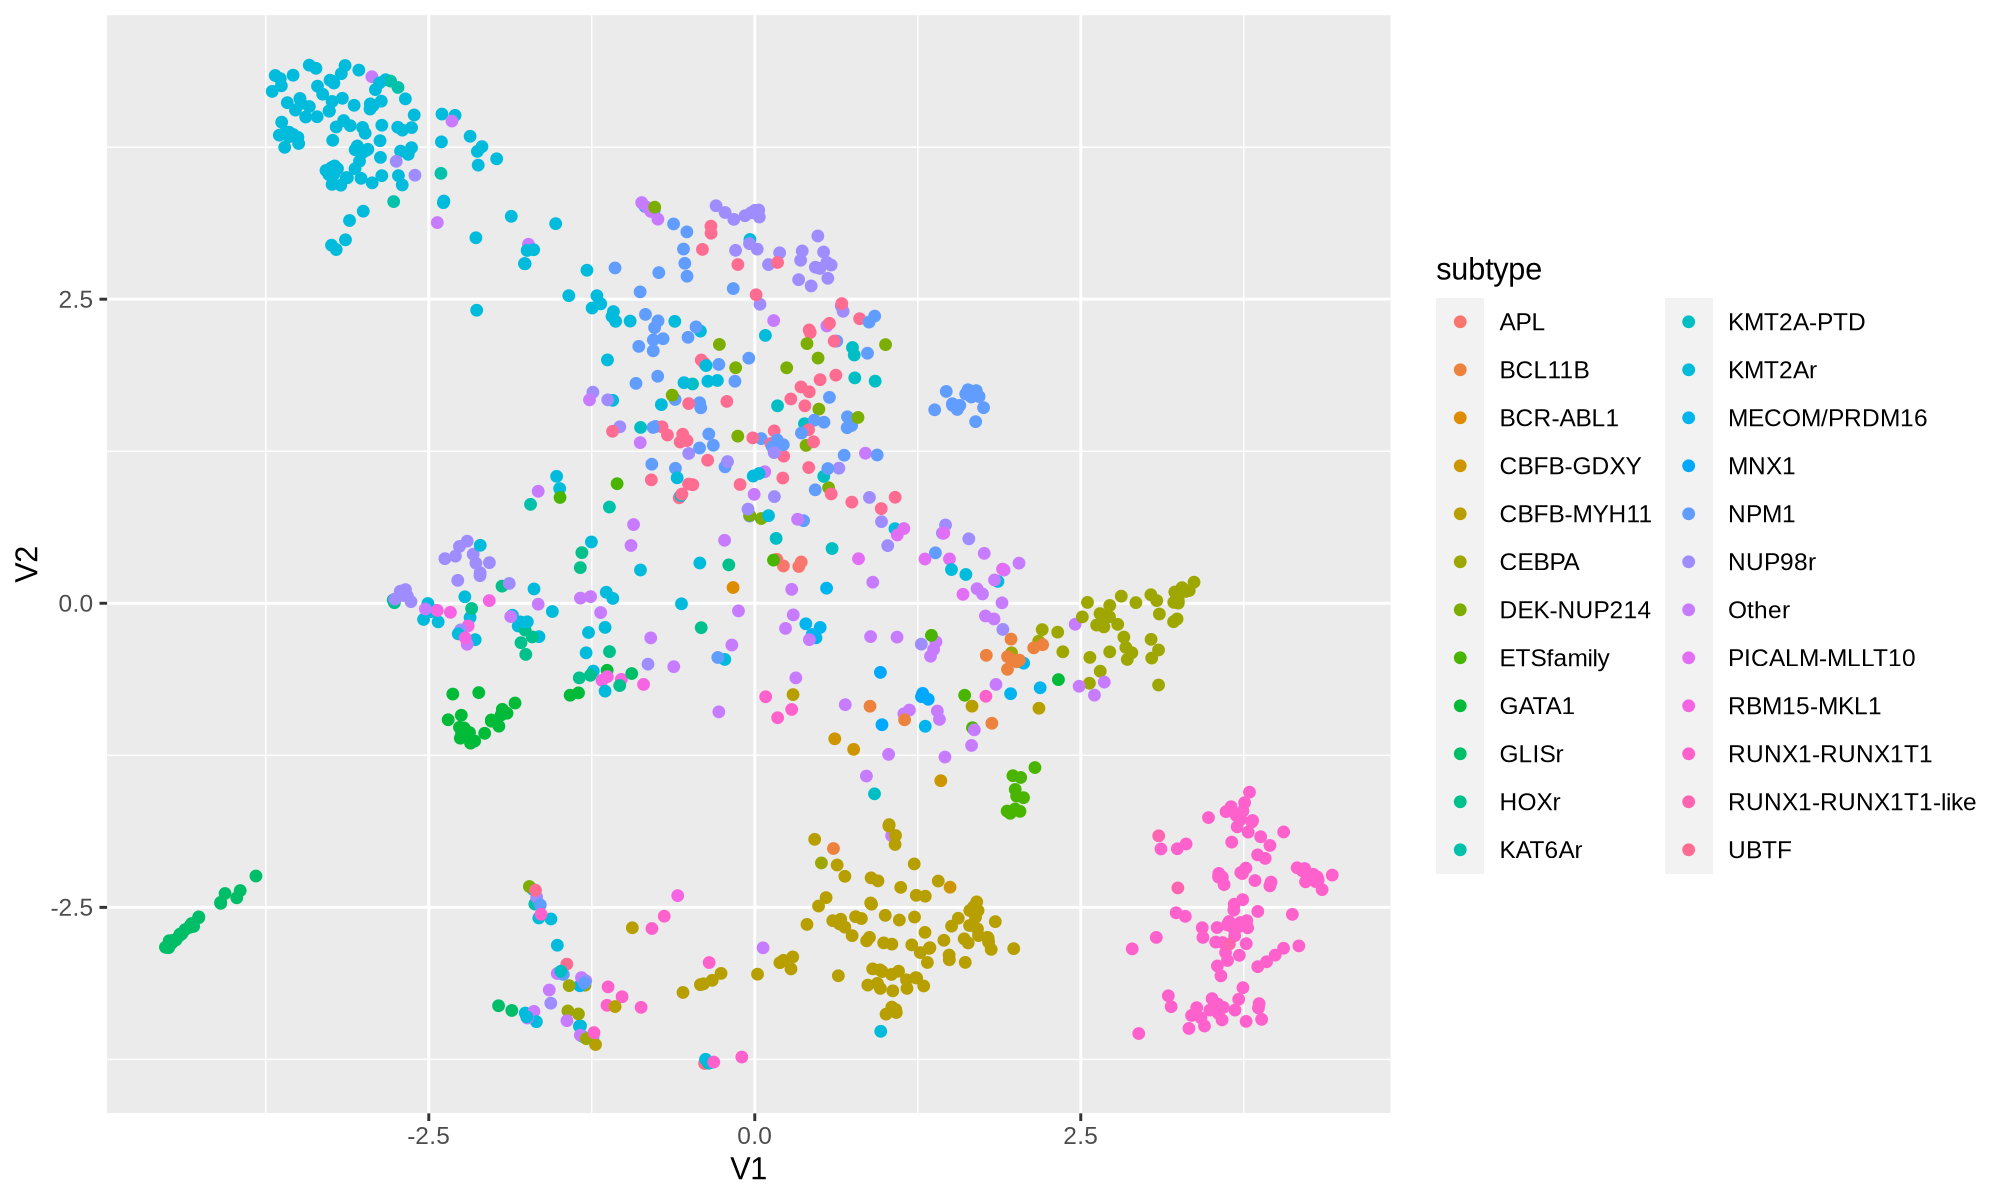

In [26]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)
ggplot(mtx_cpm_umap_layout, aes(V1, V2, color = subtype)) + geom_point()


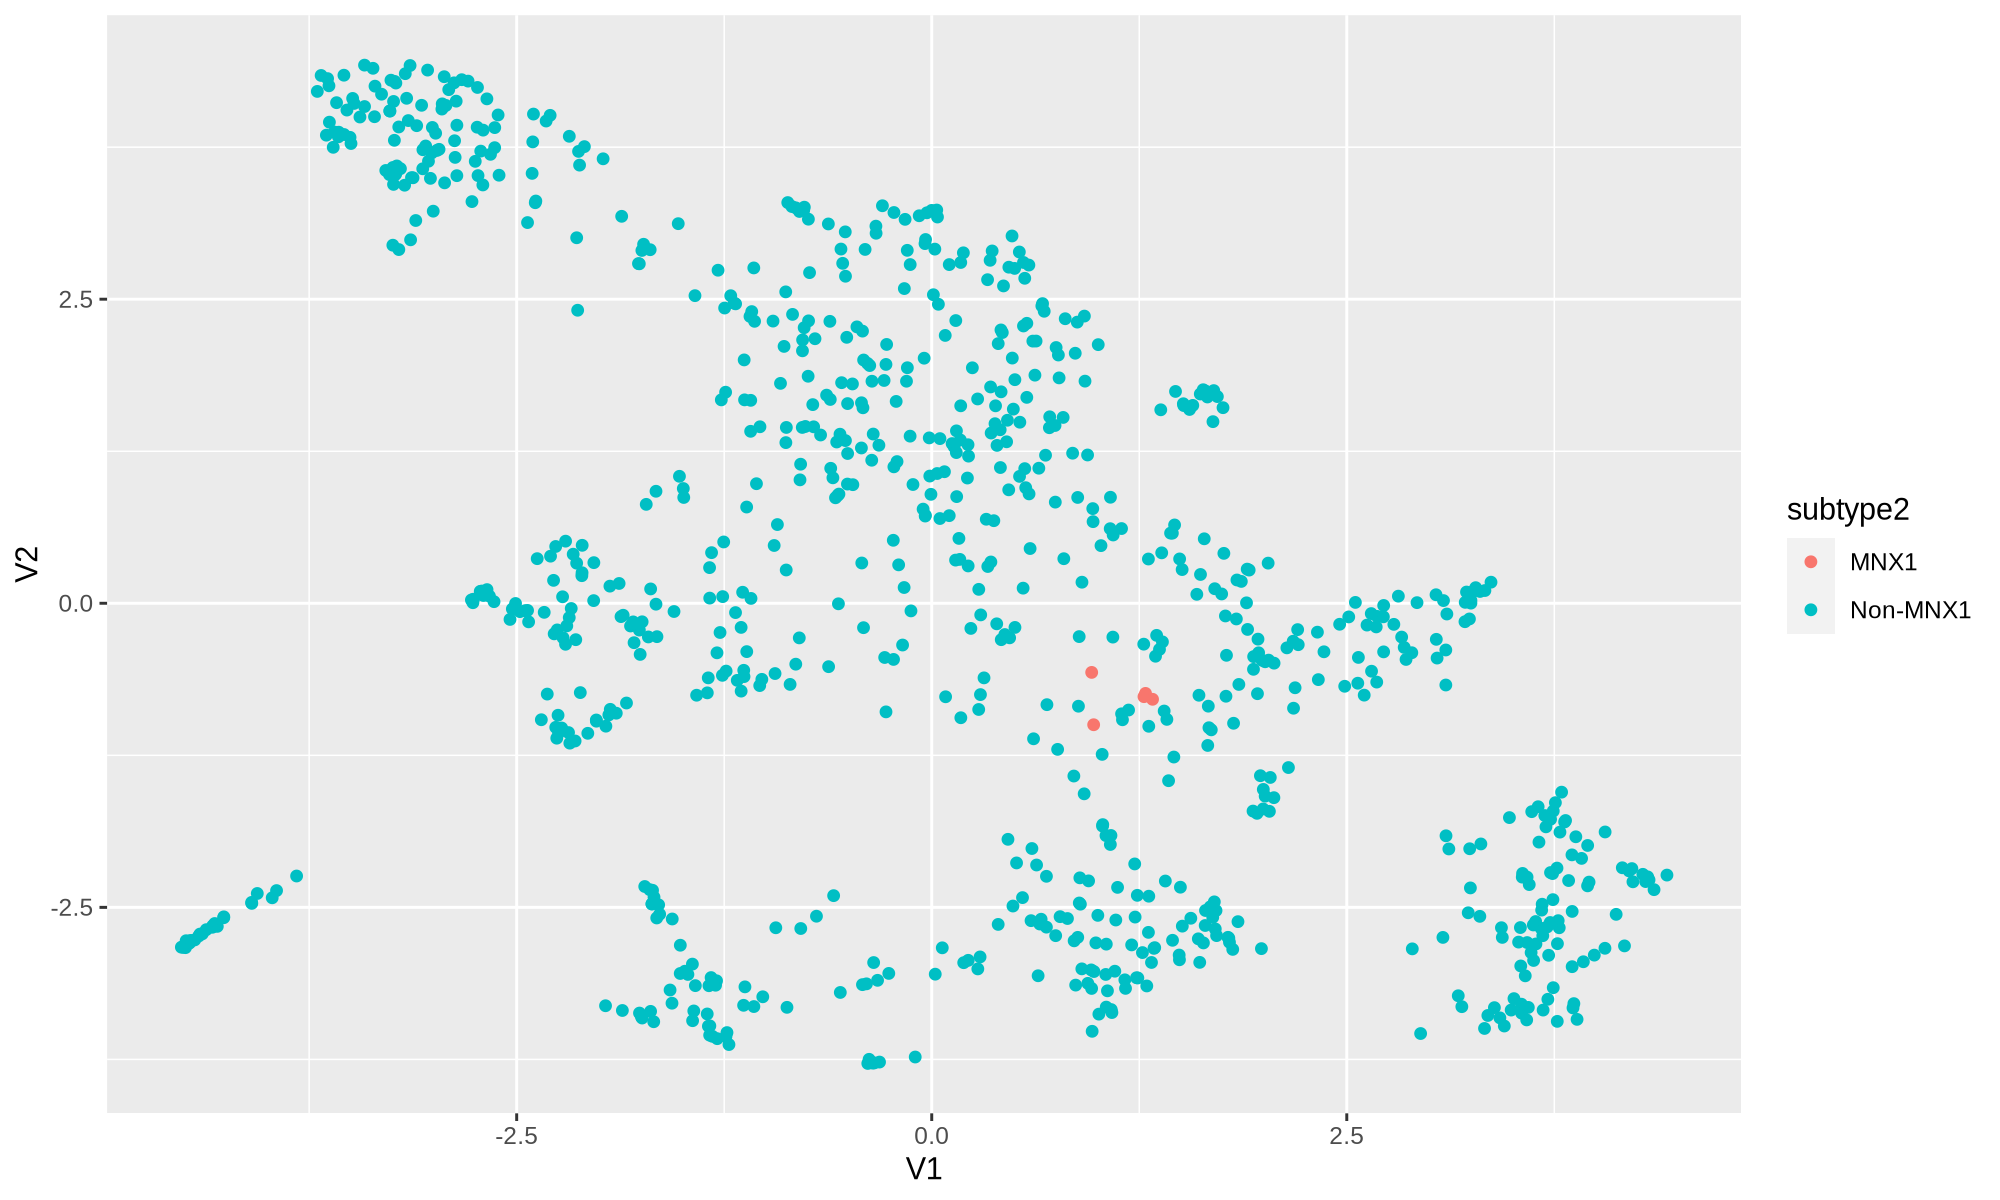

In [27]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 200)
ggplot(mtx_cpm_umap_layout, aes(V1, V2, color = subtype2)) + geom_point()


## MNX1 expression by subtype

In [36]:
head(mtx_clin)

CompBio sampleID CompBio PatientID TBID        sample source    SJUID      
1 SJCBF022_D       SJ007022          TB-03-2566  Peripheral Blood SJHBBBCNKJK
2 SJCBF030_D       SJ007030          TB-97-1197  Bone Marrow      SJHBBBHD3NS
3 SJCBF034_D       SJ007034          TB-03-1660  Bone Marrow      SJHBBBJ96HD
4 SJAML007110_D1   SJ007110          TB-09-2708  Bone Marrow      SJHBBBDFM4V
5 SJAML007122_D1   SJ007122          TB-11-2056  Bone Marrow      SJHBBBDYY97
6 SJAML030118_D1   SJ030118          TB-16-01340 Bone Marrow      SJHBBBGPGNQ
  Subject SJUID Molecular-class Defining alteration
1 SJHBBBMXN     CBFB-MYH11      CBFB-MYH11         
2 SJHBBB4RY     RUNX1-RUNX1T1   RUNX1-RUNX1T1      
3 SJHBJ7ZPP     RUNX1-RUNX1T1   RUNX1-RUNX1T1      
4 SJHBBBYJW     RUNX1-RUNX1T1   RUNX1-RUNX1T1      
5 SJHBBB2QZ     CBFB-MYH11      CBFB-MYH11         
6 SJHBB4P6M     KMT2Ar          KMT2A-MLLT3        
  BAM location                                                                                                                              
1 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJCBF022_D.bam                                                                 
2 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJCBF030_D.bam                                                                 
3 /rgs01/reference/restricted/PCGP/GRCh37-lite/TRANSCRIPTOME/SJCBF034_D.bam                                                                 
4 /rgs01/resgen/prod/tartan/index/data/Klco/AML/SJAML007110_D1/TRANSCRIPTOME/bam/SJAML007110_D1.bam                                         
5 /rgs01/resgen/prod/tartan/index/data/Klco/AML/SJAML007122_D1/TRANSCRIPTOME/bam/SJAML007122_D1.bam                                         
6 /rgs01/reference/restricted/ClinicalGenomics/clingen_raw/Clinical/2016/SJAML030118/SJAML030118_D1/TRANSCRIPTOME/mapping/SJAML030118_D1.bam
  RNA-seqStrandedness ⋯ EGA link for WGS                                
1 Unstranded          ⋯ https://ega-archive.org/datasets/EGAD00001000268
2 Unstranded          ⋯ no WGS                                          
3 Unstranded          ⋯ no WGS                                          
4 Stranded-Reverse    ⋯ no WGS                                          
5 Stranded-Reverse    ⋯ no WGS                                          
6 Stranded-Reverse    ⋯ Not Available                                   
  EGA link for WES                                
1 no WES                                          
2 https://ega-archive.org/datasets/EGAD00001002667
3 https://ega-archive.org/datasets/EGAD00001002667
4 https://ega-archive.org/datasets/EGAD00001002667
5 https://ega-archive.org/datasets/EGAD00001002667
6 Not Available                                   
  Cloud link for RNAseq                          
1 https://permalinks.stjude.cloud/permalinks/PCGP
2 https://permalinks.stjude.cloud/permalinks/PCGP
3 https://permalinks.stjude.cloud/permalinks/PCGP
4 https://permalinks.stjude.cloud/panaml         
5 https://permalinks.stjude.cloud/panaml         
6 https://permalinks.stjude.cloud/permalinks/g4k 
  Cloud link for WGS                             
1 https://permalinks.stjude.cloud/permalinks/PCGP
2 no WGS                                         
3 no WGS                                         
4 no WGS                                         
5 no WGS                                         
6 https://permalinks.stjude.cloud/permalinks/g4k 
  Cloud link for WES                             
1 no WES                                         
2 https://permalinks.stjude.cloud/permalinks/PCGP
3 https://permalinks.stjude.cloud/permalinks/PCGP
4 https://permalinks.stjude.cloud/permalinks/PCGP
5 https://permalinks.stjude.cloud/permalinks/PCGP
6 https://permalinks.stjude.cloud/permalinks/g4k 
  Paper_source_RNAseq                                                    
1 Core Binding Factor Leukemias; Faber, Z.J. et al. Nature Genetics, 2016
2 Core Binding Factor Leukemias; Faber,

In [79]:
#Molecular-class
gene_sel = c('CD33', 'CD70', 'SIGLEC6', 'MNX1')
plotdat = melt(as.data.table(t(mtx_cpm[gene_sel, ]), keep.rownames = T))
setnames(plotdat, c('sample_name', 'gene', 'logCPM'))
plotdat = merge(plotdat, mtx_clin[, .(sample_name, subtype)], by.x = 'sample_name', by.y = 'sample_name', all.x = T)
head(plotdat)


Warning message in melt.data.table(as.data.table(t(mtx_cpm[gene_sel, ]), keep.rownames = T)):
"id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [rn, ...]. Consider providing at least one of 'id' or 'measure' vars in future."


sample_name    gene    logCPM       subtype
1 SJAEL011880_D1 CD33     5.428479823 UBTF   
2 SJAEL011880_D1 CD70    -0.913580027 UBTF   
3 SJAEL011880_D1 SIGLEC6 -0.270059668 UBTF   
4 SJAEL011880_D1 MNX1    -5.868921460 UBTF   
5 SJAEL011881_D1 CD33     4.100614244 NUP98r 
6 SJAEL011881_D1 CD70     0.004274644 NUP98r

In [80]:
plotdat[is.na(subtype), subtype := 'CD34'] 
plotdat[, clr := 'grey']
plotdat[subtype == 'MNX1', clr := 'blue']
plotdat[is.na(subtype), ]

sample_name gene logCPM subtype clr

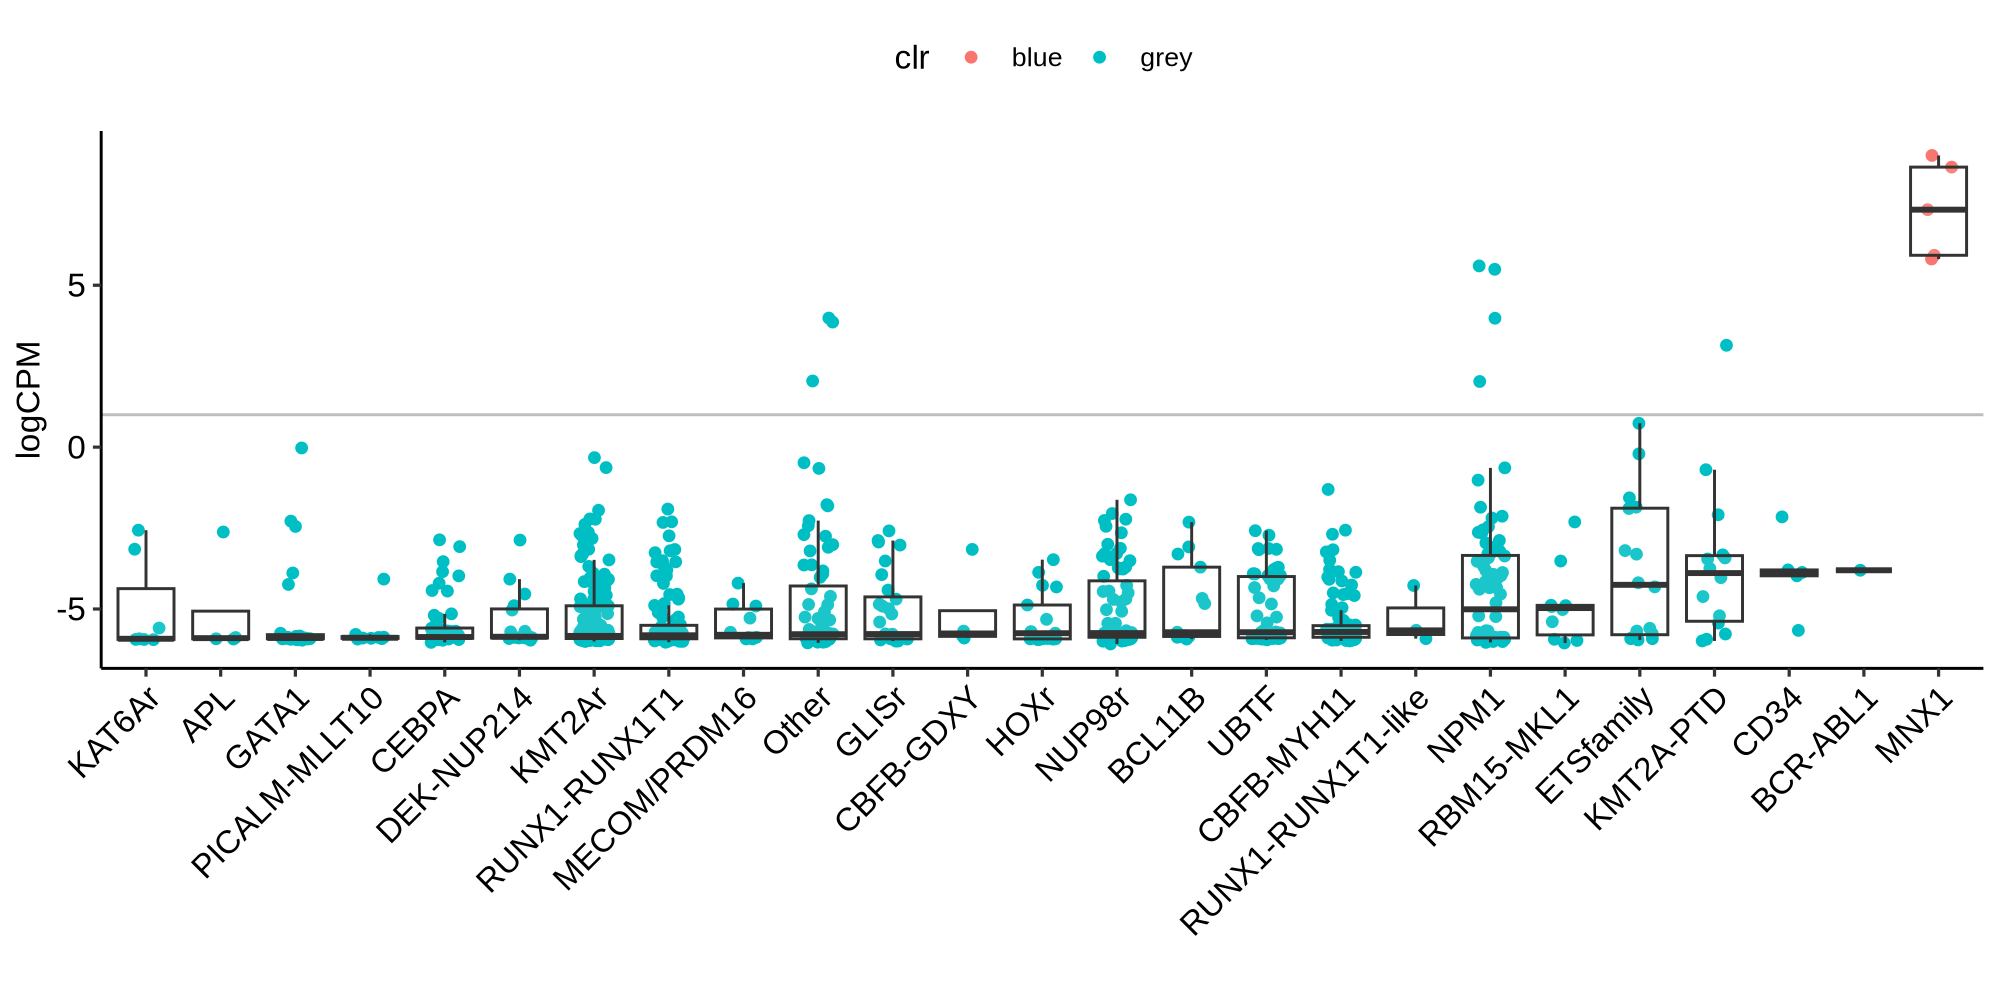

In [83]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res  =200)
plotdat2 = plotdat[gene == 'MNX1', ]
ggplot(plotdat2, aes(reorder(subtype, logCPM, median), logCPM)) + geom_jitter(aes(color = clr), width = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + xlab('') + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + geom_hline(yintercept = 1, color = 'grey')


# BCAT1 expression 

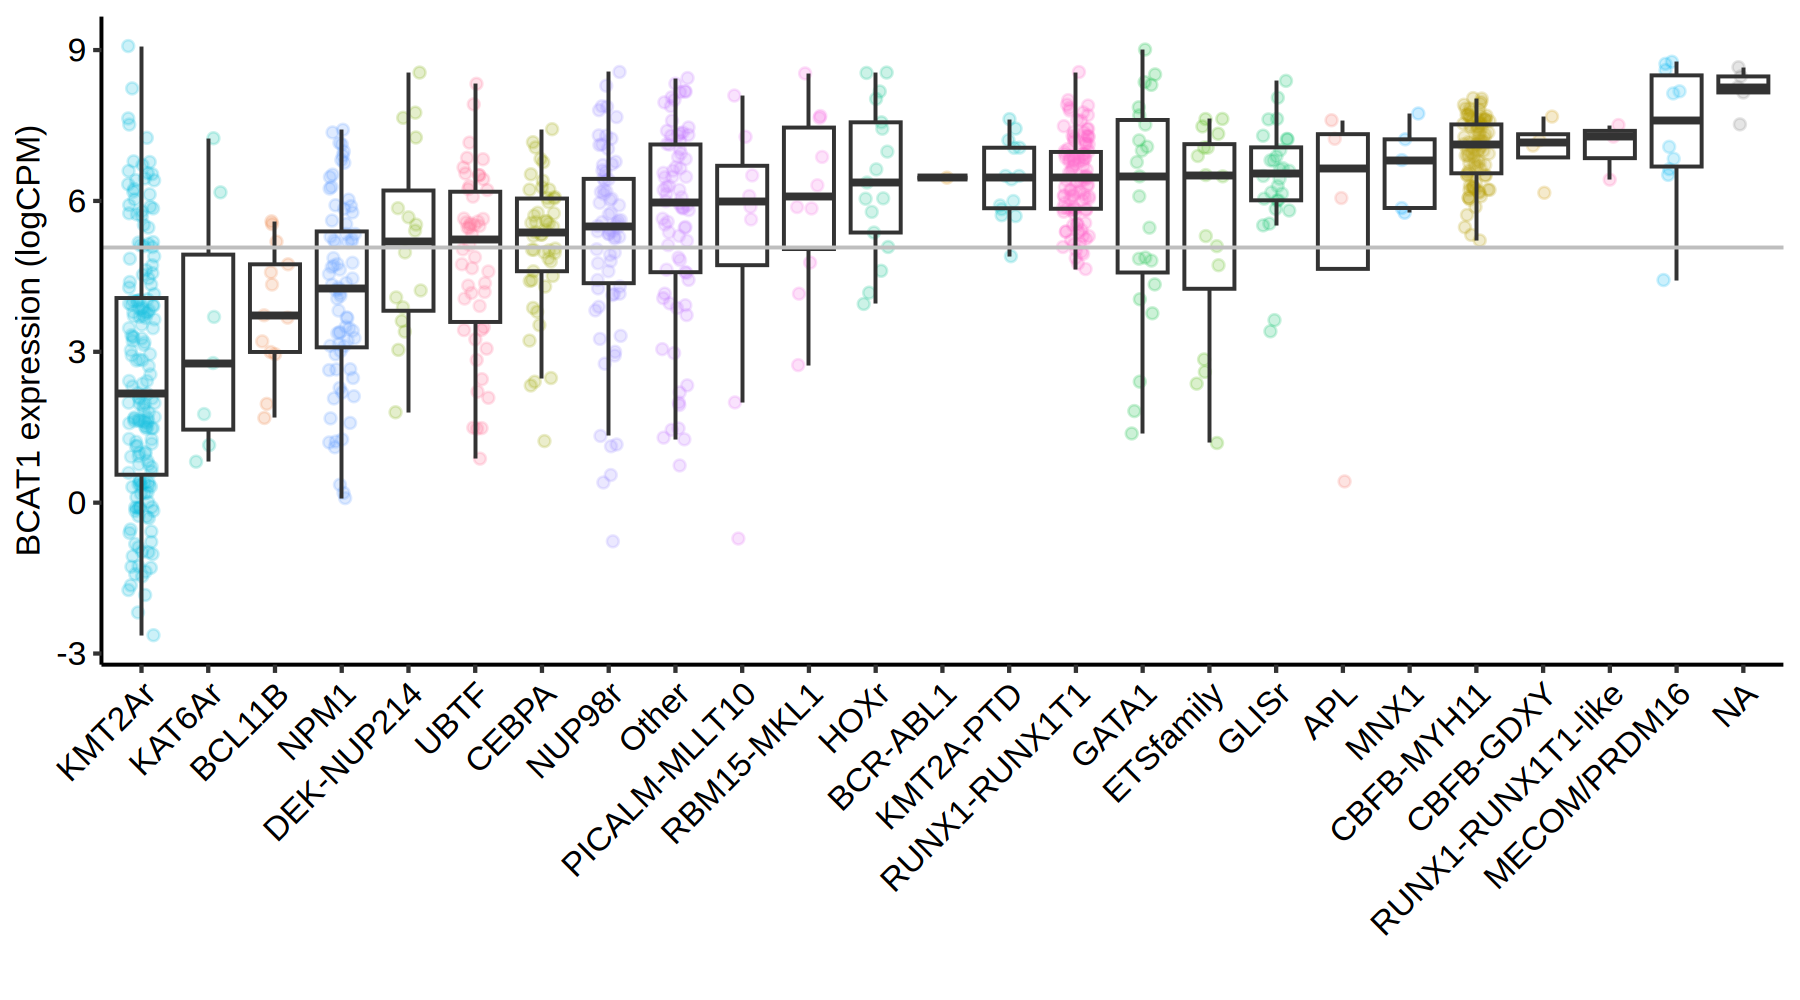

In [43]:
options(repr.plot.width = 9, repr.plot.height = 5, repr.plot.res  =200)

plotdat = mtx_cpm_t_2[, .(BCAT1, subtype)]
plotdat[, logCPM := BCAT1 ]
mm = mean(plotdat$logCPM, na.rm = T)
ggplot(plotdat, aes(reorder(subtype, logCPM, median), logCPM)) + geom_jitter(aes(color = subtype), width = .2, alpha = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + xlab('') + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1), legend.position="none") + geom_hline(yintercept = mm, color = 'grey') +
ylab('BCAT1 expression (logCPM)')



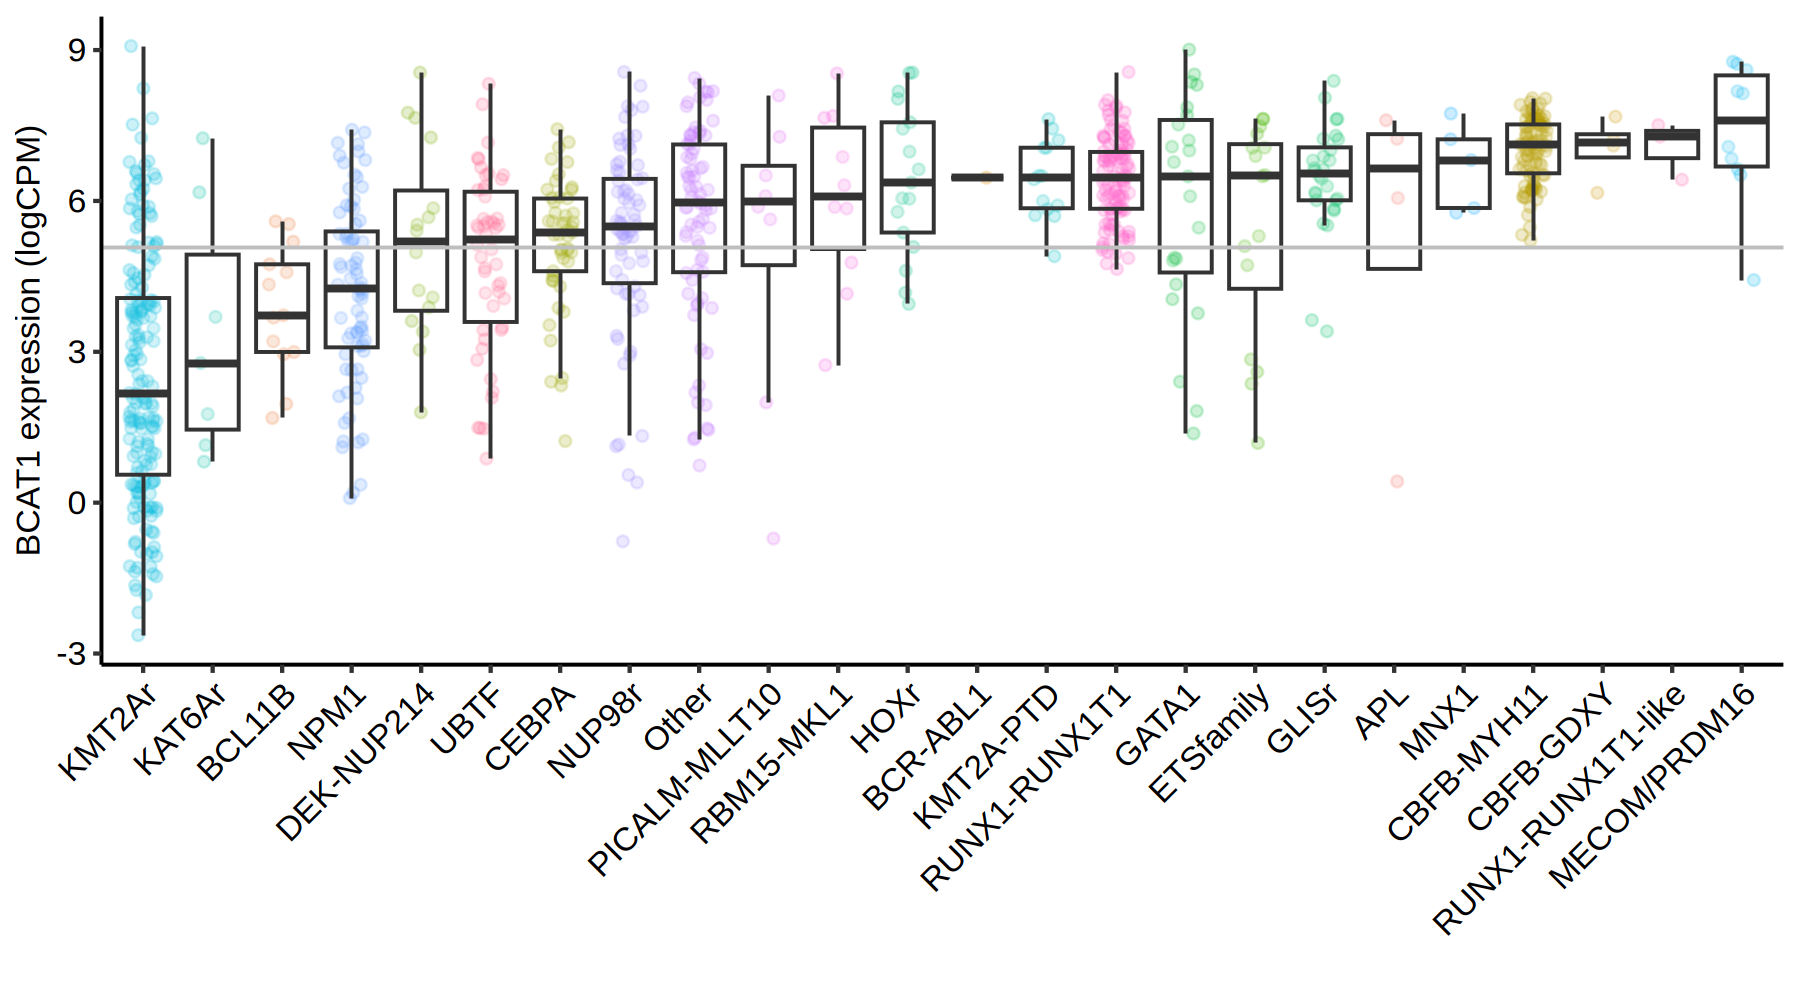

In [41]:
options(repr.plot.width = 9, repr.plot.height = 5, repr.plot.res  =200)

plotdat = mtx_cpm_t_2[!is.na(subtype), .(BCAT1, subtype)]
plotdat[, logCPM := BCAT1 ]
mm = mean(plotdat$logCPM, na.rm = T)
ggplot(plotdat, aes(reorder(subtype, logCPM, median), logCPM)) + geom_jitter(aes(color = subtype), width = .2, alpha = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1h) + xlab('') + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1), legend.position="none") + geom_hline(yintercept = mm, color = 'grey') +
ylab('BCAT1 expression (logCPM)')



In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res  =200)
plotdat2 = plotdat[gene == 'MNX1', ]
ggplot(plotdat2, aes(reorder(subtype, logCPM, median), logCPM)) + geom_jitter(aes(color = clr), width = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + xlab('') + 
theme_pubr() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + geom_hline(yintercept = 1, color = 'grey')


# export 

In [28]:
saveRDS(mtx_cpm_t_2, file = 'mtx_cpm_t_2.rds')

# MNX1 DEG vs all others

## vs pAML DEG

In [28]:
mtx_clin[, mnx_subtype := 'None']
mtx_clin[grep('MNX', subtype), mnx_subtype := 'MNX1']
mtx_clin[, mnx_subtype := factor(mnx_subtype, levels = c('None', 'MNX1'))]
ov = intersect(colnames(mtx), mtx_clin$sample_name)

setkey(mtx_clin, 'sample_name')
mtx_clin_exp = mtx_clin[ov, ] 
mtx_clin_exp_df = setDF(mtx_clin_exp, rownames = mtx_clin_exp$sample_name)

mtx_exp = mtx[, ov]


In [ ]:
dds_all <- DESeqDataSetFromMatrix( countData = mtx_exp,
                                  design = ~ mnx_subtype, colData = mtx_clin_exp_df)
dds_all <- DESeq(dds_all, test="Wald")
saveRDS(dds_all, file = 'data/nb_clin_AML_mar22_dds_all.rds')


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 5029 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions



In [59]:
dds_all = readRDS('data/nb_clin_AML_mar22_dds_all.rds')


In [263]:
res_all = results(dds_all)
res_all = as.data.table(res_all, keep.rownames = T) 
res_all = res_all[order(padj), ]


Warning message in .local(x, row.names, optional, ...):
"Arguments in '...' ignored"


In [258]:
dds <- DESeqDataSetFromMatrix(
    countData = mtx_exp,
    design = ~ mnx_subtype,
    colData = mtx_clin_exp_df)
smallestGroupSize <- 15
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]
dds <- DESeq(dds, test="Wald")
saveRDS(dds, file = 'data/nb_clin_AML_mar22_dds.rds')


estimating size factors

estimating dispersions

gene-wise dispersion estimates



In [60]:
dds = readRDS('data/nb_clin_AML_mar22_dds.rds')


Warning message in gzfile(file, "rb"):
"cannot open compressed file 'data/nb_clin_AML_mar22_dds.rds', probable reason 'No such file or directory'"


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [32]:
res = results(dds)
res = as.data.table(res, keep.rownames = T) 
res = res[order(padj), ]


Warning message in .local(x, row.names, optional, ...):
"Arguments in '...' ignored"


In [61]:
#fwrite(res, file = 'data/DEG_MNX1_vs_all_other_pAML.xls', sep = '\t')
res = fread('data/DEG_MNX1_vs_all_other_pAML.xls', sep = '\t')


In [65]:
res[rn %in% gene_sel, ]


rn      baseMean   log2FoldChange lfcSE     stat     pvalue      
1 MNX1      50.65322 9.960430       1.9837555 5.020997 5.140396e-07
2 SIGLEC6  197.21521 2.667288       0.8669445 3.076654 2.093380e-03
3 CD33    2418.22643 1.162183       0.5659056 2.053670 4.000768e-02
4 CD70     203.59520 1.656045       1.0465169 1.582435 1.135504e-01
  padj        
1 0.0000964124
2 0.0494393481
3 0.2587085526
4 0.4311810981

Warning message:
"Removed 5208 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 27691 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


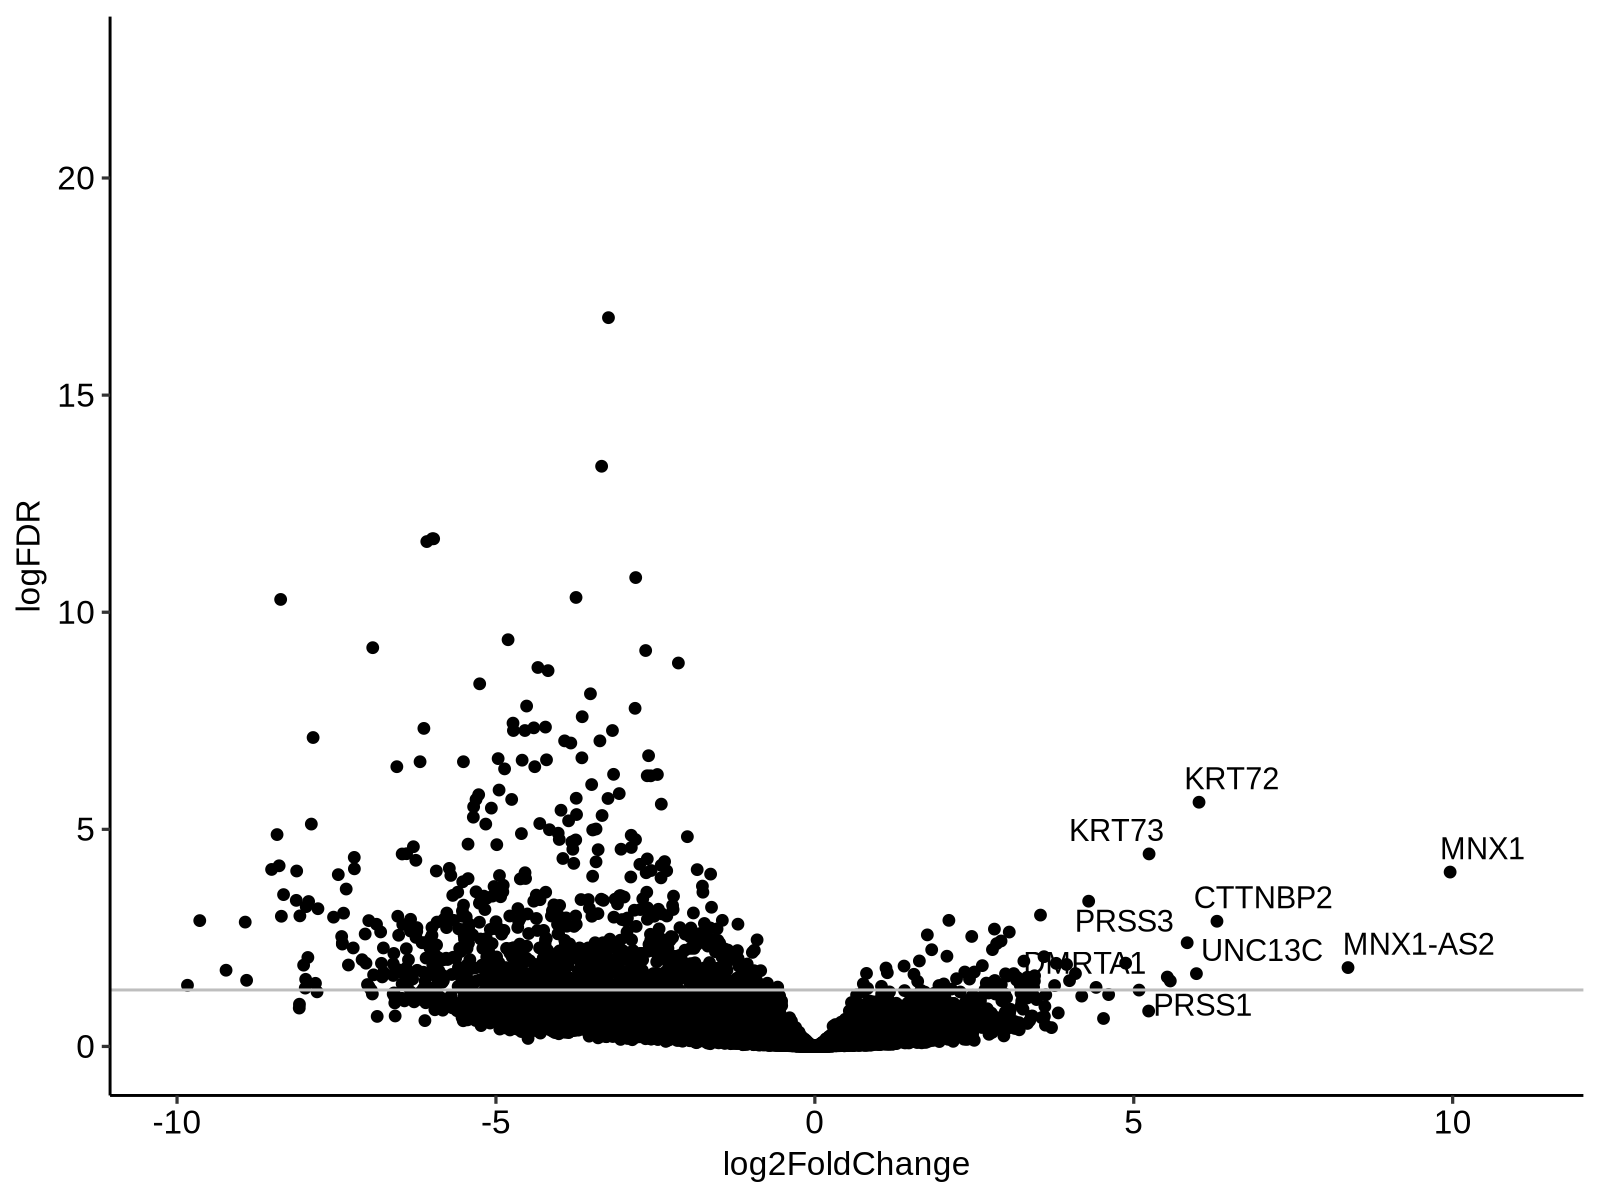

In [63]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = copy(res)
plotdat[log2FoldChange < -10, lbl := rn]
plotdat[log2FoldChange > 5 & padj < 0.05, lbl := rn]
plotdat[, logFDR := -log(padj, 10)] 
ggplot(plotdat, aes(log2FoldChange, logFDR, label = lbl)) + geom_point() + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel() + xlim(-10, 11)


## DEG by edgeR

In [ ]:
mtx_clin[, mnx_subtype := 'None']
mtx_clin[grep('MNX', subtype), mnx_subtype := 'MNX1']
mtx_clin[, mnx_subtype := factor(mnx_subtype, levels = c('None', 'MNX1'))]
ov = intersect(colnames(mtx), mtx_clin$sample_name)

setkey(mtx_clin, 'sample_name')
mtx_clin_exp = mtx_clin[ov, ] 
mtx_clin_exp_df = setDF(mtx_clin_exp, rownames = mtx_clin_exp$sample_name)

mtx_exp = mtx[, ov]

mtx2 = mtx_exp[, rownames(mtx_clin_exp_df)]

condition = factor(mtx_clin_exp_df$mnx_subtype, levels = c('None', 'MNX1'))

dge = DGEList(counts = mtx2, group = condition)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
dge = normLibSizes(dge)
design = model.matrix( ~ condition)
dge = estimateDisp(dge, design)
fit = glmFit(dge, design)
lrt = glmLRT(fit, coef=2)

res_jude = topTags(lrt, n = nrow(mtx2))
res_jude = as.data.table(res_jude$table, keep.rownames = T)
head(res_jude)

logcpm_jude = cpm(dge, log=TRUE)
logcpm_jude[1:10, 1:10]

save(res_jude, file = 'data/bn_clin_AML_edgeR_res_jude.rds')
save(logcpm_jude, file = 'data/bn_clin_AML_edgeR_logcpm_jude.rds')


In [49]:
head(res_jude)

rn       logFC     logCPM      LR       PValue       FDR         
1 MNX1     10.146482  0.67123381 389.3920 1.122636e-86 3.606694e-82
2 KRT72     6.054309  0.45792190 208.8120 2.494921e-47 4.007716e-43
3 CTTNBP2   6.612915 -1.13177947 163.7809 1.688957e-37 1.808704e-33
4 MNX1-AS2  8.365052 -2.83321755 150.2014 1.566533e-34 1.258200e-30
5 KRT73     5.296268  0.02365878 136.2104 1.794718e-31 1.153178e-27
6 UNC13C    6.301294 -1.06748459  90.5397 1.813025e-21 9.707844e-18

In [55]:
gene_sel = c('SIGLEC6', 'CD33', 'CD70', 'MNX1')


In [64]:
res_jude[rn %in% gene_sel, ] 


rn      logFC     logCPM    LR         PValue       FDR         
1 MNX1    10.146482 0.6712338 389.392003 1.122636e-86 3.606694e-82
2 SIGLEC6  2.659845 2.5484099  19.012176 1.298870e-05 3.628591e-03
3 CD33     1.150481 6.1841032   5.326752 2.100049e-02 3.916863e-01
4 CD70     1.697928 2.5968846   4.049745 4.417802e-02 4.836760e-01

Warning message:
"Removed 32106 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


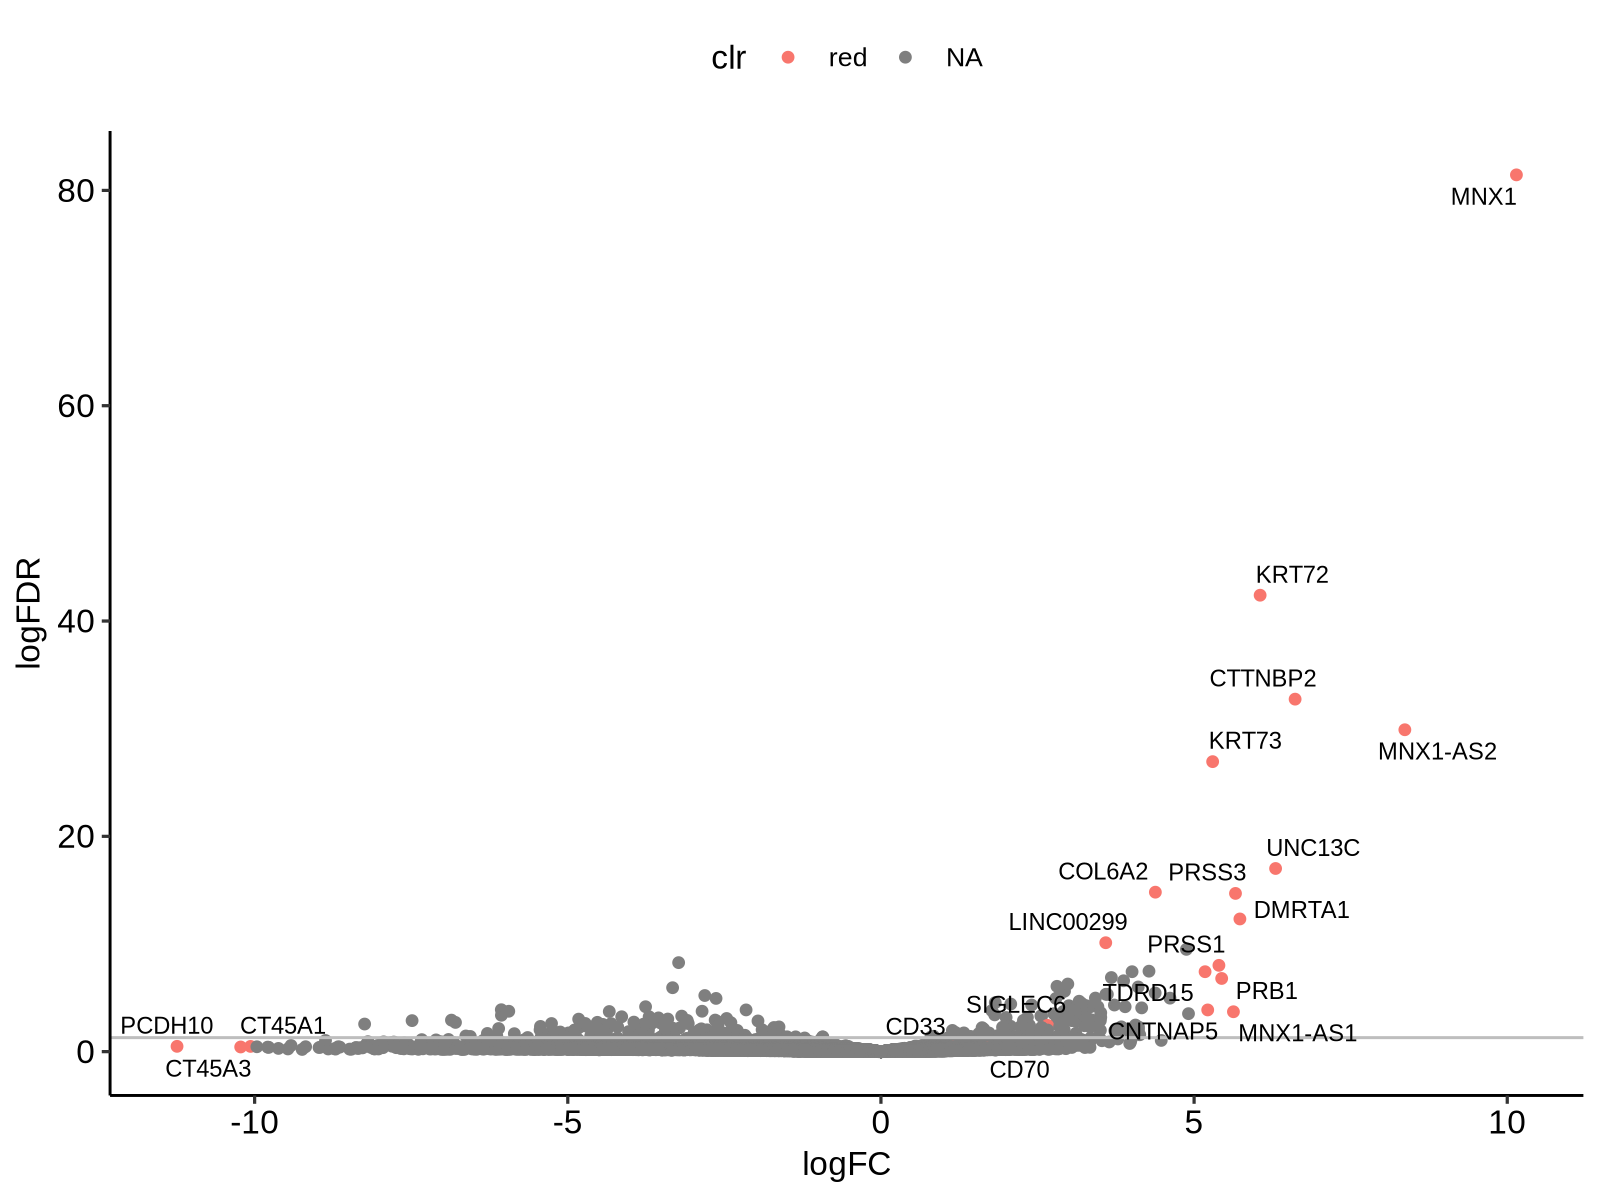

In [70]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = copy(res_jude)
plotdat[logFC < -10, lbl := rn]
plotdat[logFC > 5 & FDR < 0.05, lbl := rn]
plotdat[rn %in% gene_sel, lbl := rn]
plotdat[, logFDR := -log(FDR, 10)] 
plotdat[logFDR > 10, lbl := rn]
plotdat[!is.na(lbl), clr := 'red'] 
ggplot(plotdat, aes(logFC, logFDR, label = lbl)) + geom_point(aes(color = clr)) + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel(size = 3)


Warning message:
"Removed 32114 rows containing missing values or values outside the scale range
(`geom_text_repel()`)."


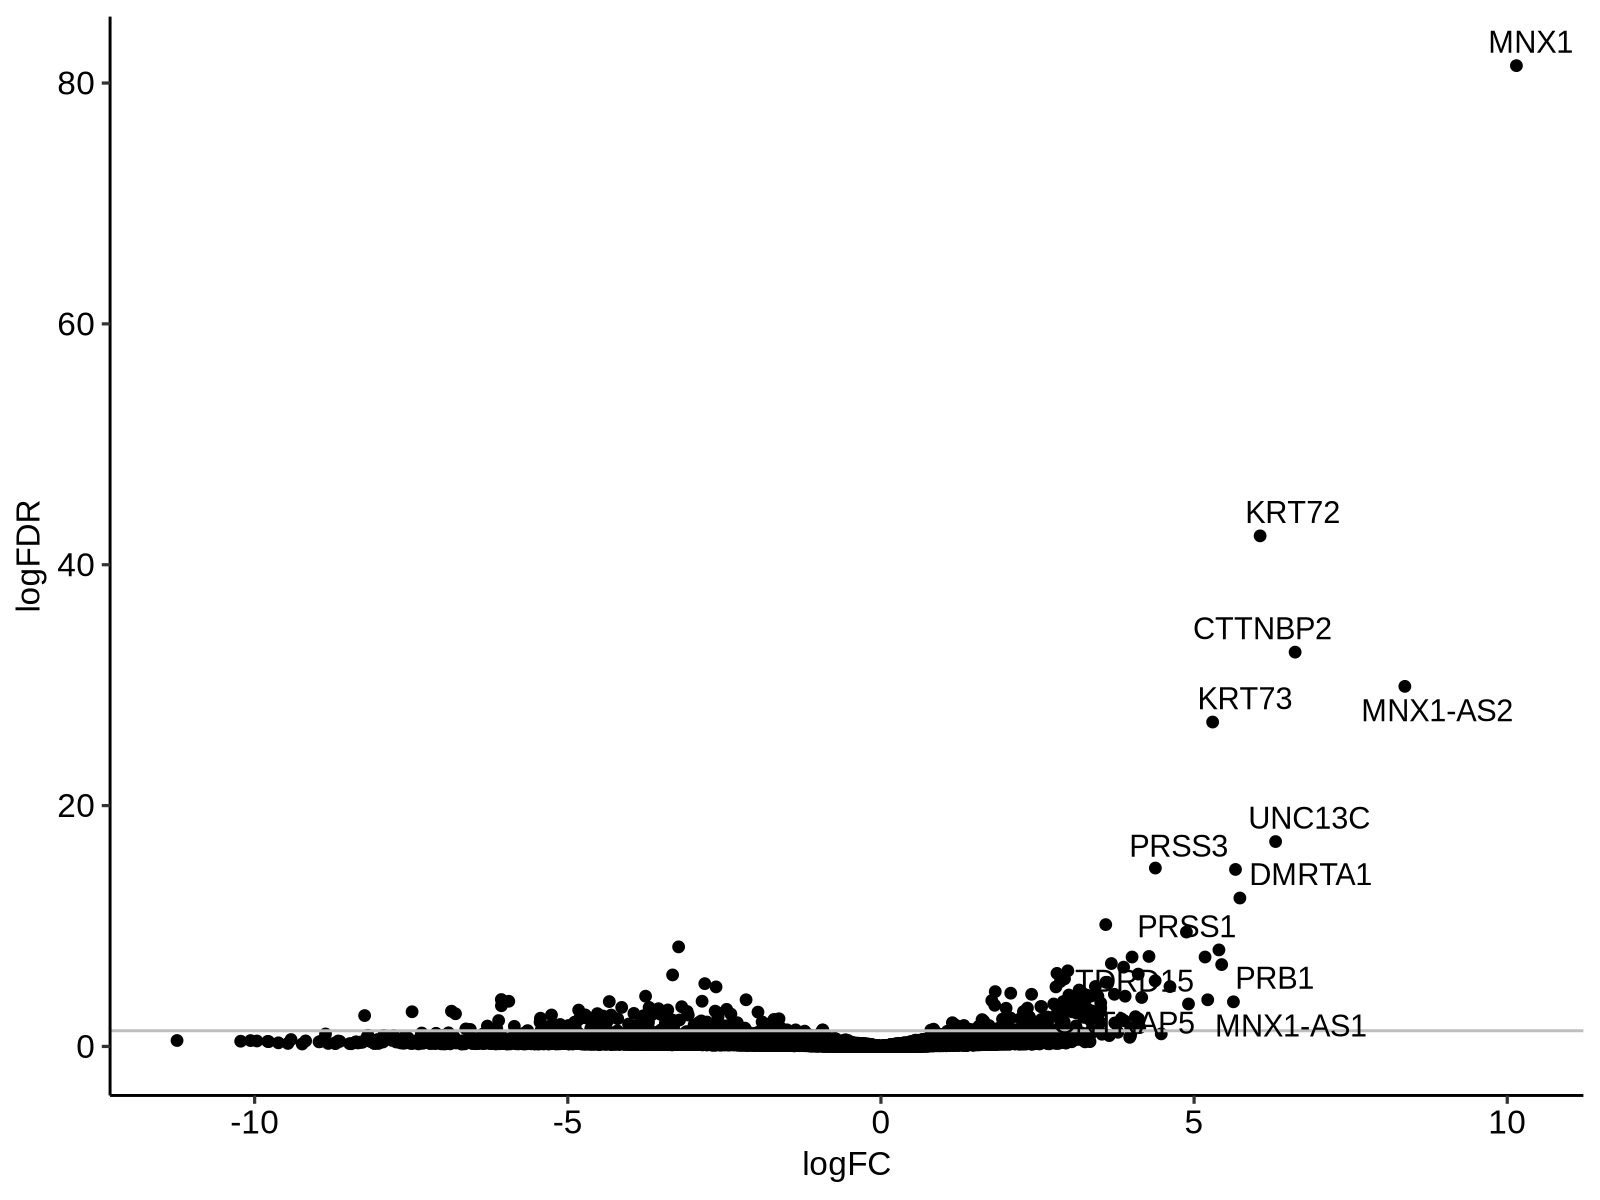

In [56]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = copy(res_jude)
plotdat[logFC < -10  & FDR < 0.05, lbl := rn]
plotdat[logFC > 5 & FDR < 0.05, lbl := rn]
plotdat[logFC > 5 & FDR < 0.05 & rn %in% gene_sel, lbl := rn]
plotdat[, logFDR := -log(FDR, 10)] 
ggplot(plotdat, aes(logFC, logFDR, label = lbl)) + geom_point() + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel()


## target gene expression 


In [66]:
res[rn %in% gene_sel, ]


rn      baseMean   log2FoldChange lfcSE     stat     pvalue      
1 MNX1      50.65322 9.960430       1.9837555 5.020997 5.140396e-07
2 SIGLEC6  197.21521 2.667288       0.8669445 3.076654 2.093380e-03
3 CD33    2418.22643 1.162183       0.5659056 2.053670 4.000768e-02
4 CD70     203.59520 1.656045       1.0465169 1.582435 1.135504e-01
  padj        
1 0.0000964124
2 0.0494393481
3 0.2587085526
4 0.4311810981

In [90]:
plotdat[, subtype2 := 'Other']
interID = plotdat2[logCPM > 1, sample_name] 
plotdat[sample_name %in% interID, subtype2 := 'Inter']
mnxID = plotdat2[subtype == 'MNX1', sample_name]
plotdat[sample_name %in% mnxID, subtype2 := 'MNX1']
plotdat[, subtype2 := factor(subtype2, levels = c('Other', 'Inter', 'MNX1'))]


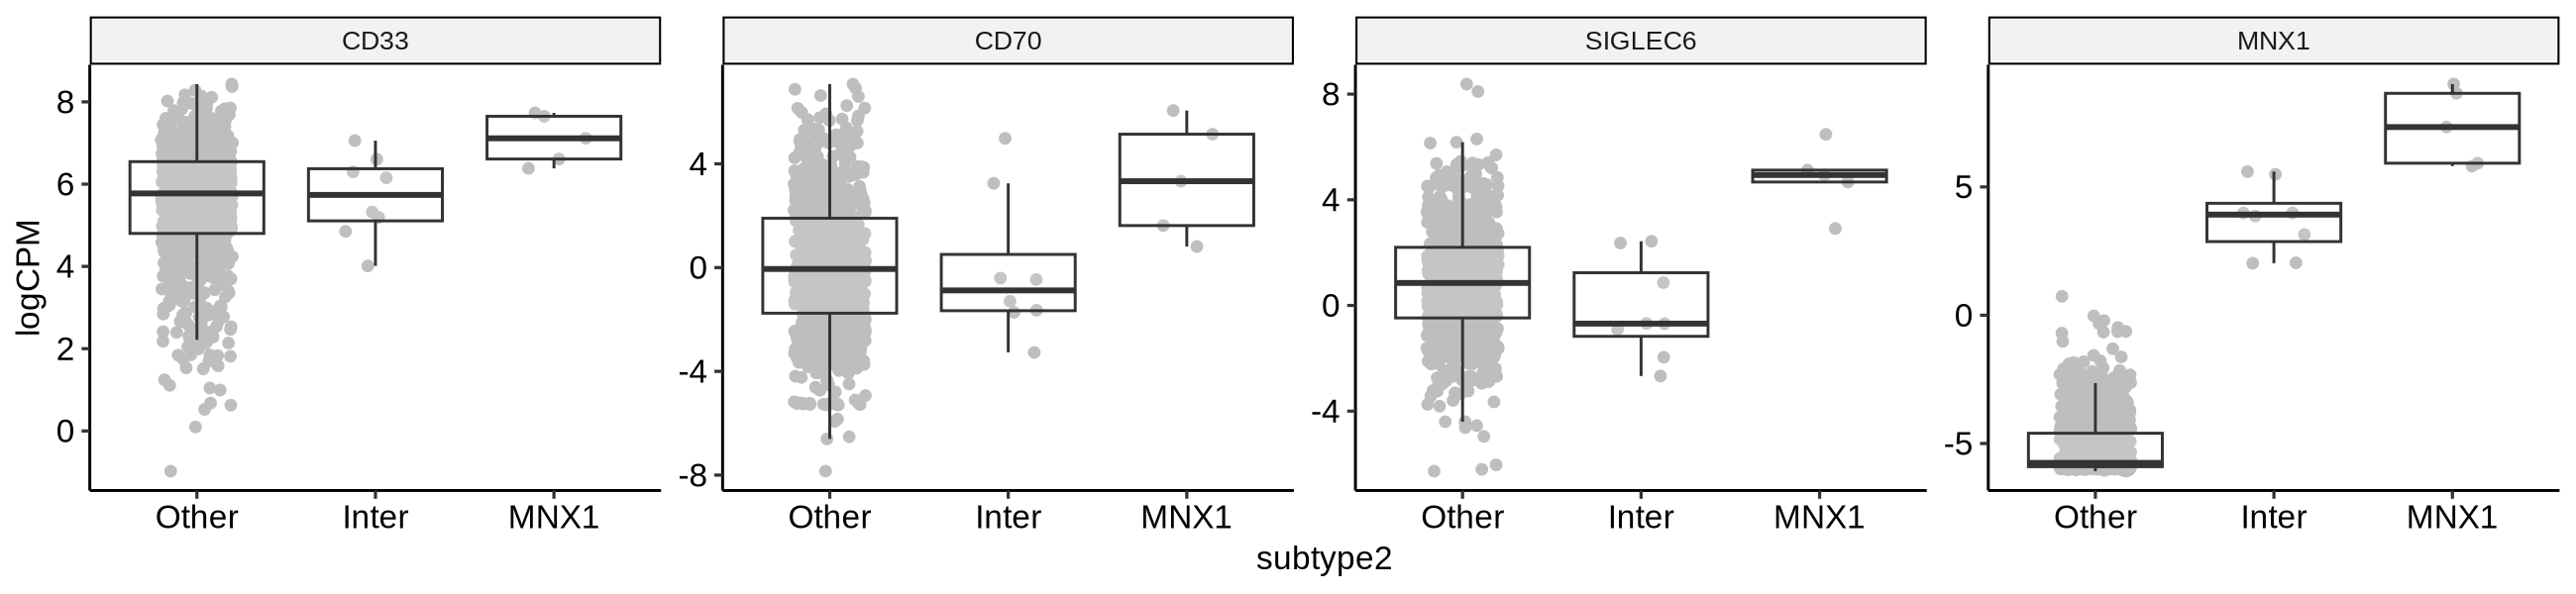

In [93]:
options(repr.plot.width = 13, repr.plot.height = 3, repr.plot.res = 200)
ggplot(plotdat, aes(x = subtype2, logCPM)) + geom_jitter(color = 'grey', width = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + theme_pubr() + facet_wrap(~ gene, nrow = 1, scales = 'free')

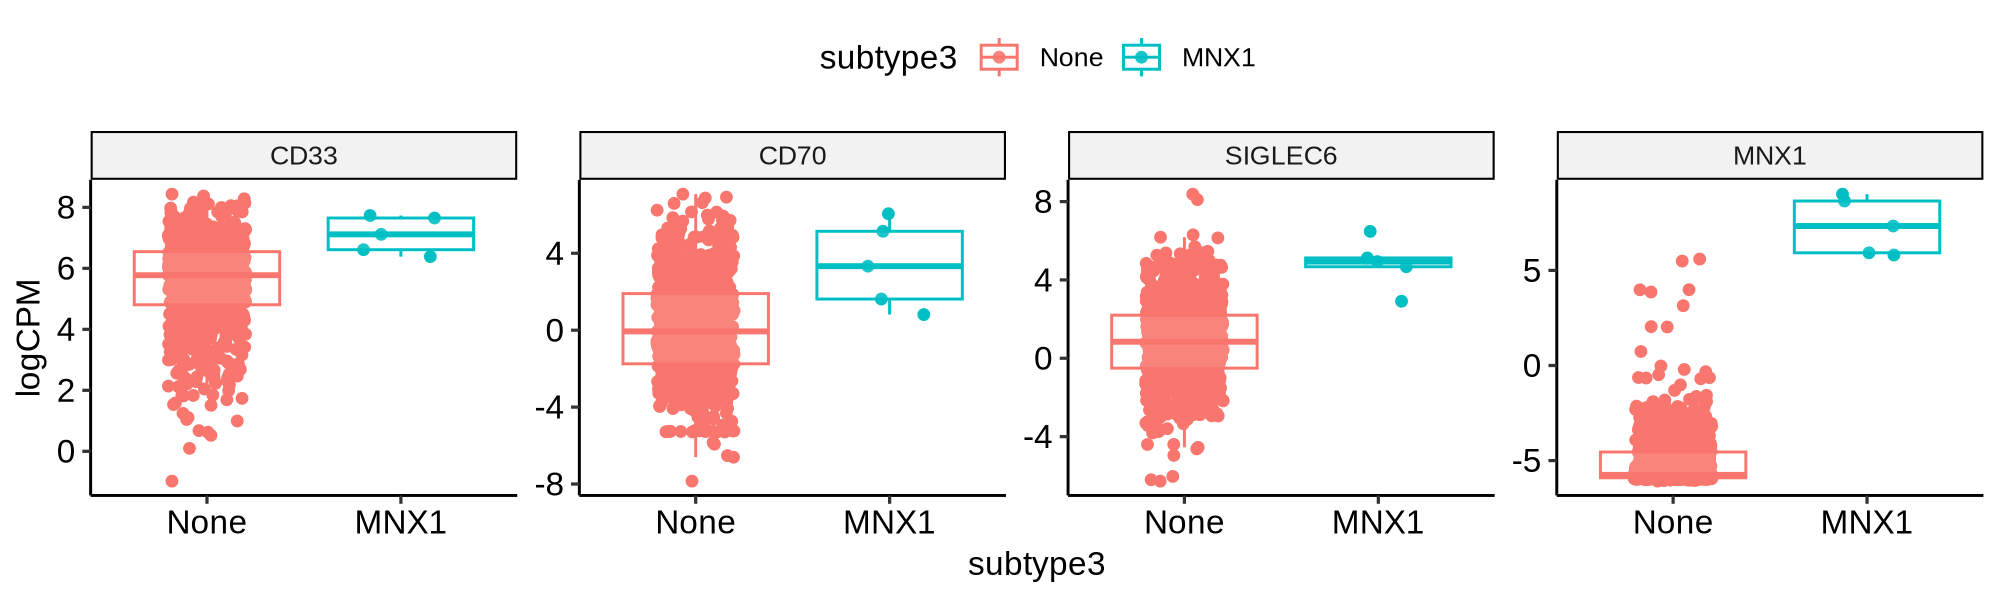

In [101]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
plotdat[, subtype3 := 'None']
plotdat[subtype == 'MNX1', subtype3 := 'MNX1']
plotdat[, subtype3 := factor(subtype3, levels = c('None', 'MNX1'))]

ggplot(plotdat, aes(x = subtype3, logCPM, color = subtype3)) + geom_jitter(width = .2) + geom_boxplot(outlier.alpha = 0, alpha = .1) + theme_pubr() + facet_wrap(~ gene, nrow = 1, scales = 'free')


In [73]:
plotdat2[, MNX1_level_subtype := subtype]
plotdat[MNX1 > 1, MNX1_level_subtype := 'median_MNX1']
dsn2 = copy(plotdat)


In [119]:
summary(aov(logCPM ~ subtype2, data = plotdat[gene == 'SIGLEC6', ]))


             Df Sum Sq Mean Sq F value   Pr(>F)    
subtype2      2     86   42.94   9.737 6.56e-05 ***
Residuals   889   3920    4.41                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [106]:
wilcox.test(x= plotdat[gene == 'SIGLEC6' & subtype3 == 'MNX1', logCPM] ,  y= plotdat[gene == 'SIGLEC6' & subtype3 == 'None', logCPM] ) 


	Wilcoxon rank sum test with continuity correction

data:  plotdat[gene == "SIGLEC6" & subtype3 == "MNX1", logCPM] and plotdat[gene == "SIGLEC6" & subtype3 == "None", logCPM]
W = 4212, p-value = 0.0005187
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  plotdat[gene == "CD33" & subtype3 == "MNX1", logCPM] and plotdat[gene == "CD33" & subtype3 == "None", logCPM]
W = 3822, p-value = 0.005238
alternative hypothesis: true location shift is not equal to 0


In [107]:
wilcox.test(x= plotdat[gene == 'CD33' & subtype3 == 'MNX1', logCPM] ,  y= plotdat[gene == 'CD33' & subtype3 == 'None', logCPM] ) 



	Wilcoxon rank sum test with continuity correction

data:  plotdat[gene == "CD33" & subtype3 == "MNX1", logCPM] and plotdat[gene == "CD33" & subtype3 == "None", logCPM]
W = 3822, p-value = 0.005238
alternative hypothesis: true location shift is not equal to 0


In [108]:
wilcox.test(x= plotdat[gene == 'CD70' & subtype3 == 'MNX1', logCPM] ,  y= plotdat[gene == 'CD70' & subtype3 == 'None', logCPM] ) 



	Wilcoxon rank sum test with continuity correction

data:  plotdat[gene == "CD70" & subtype3 == "MNX1", logCPM] and plotdat[gene == "CD70" & subtype3 == "None", logCPM]
W = 3714, p-value = 0.009213
alternative hypothesis: true location shift is not equal to 0


## vs pAML MAPLot

Warning message:
"Removed 5208 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 27688 rows containing missing values (`geom_text_repel()`)."


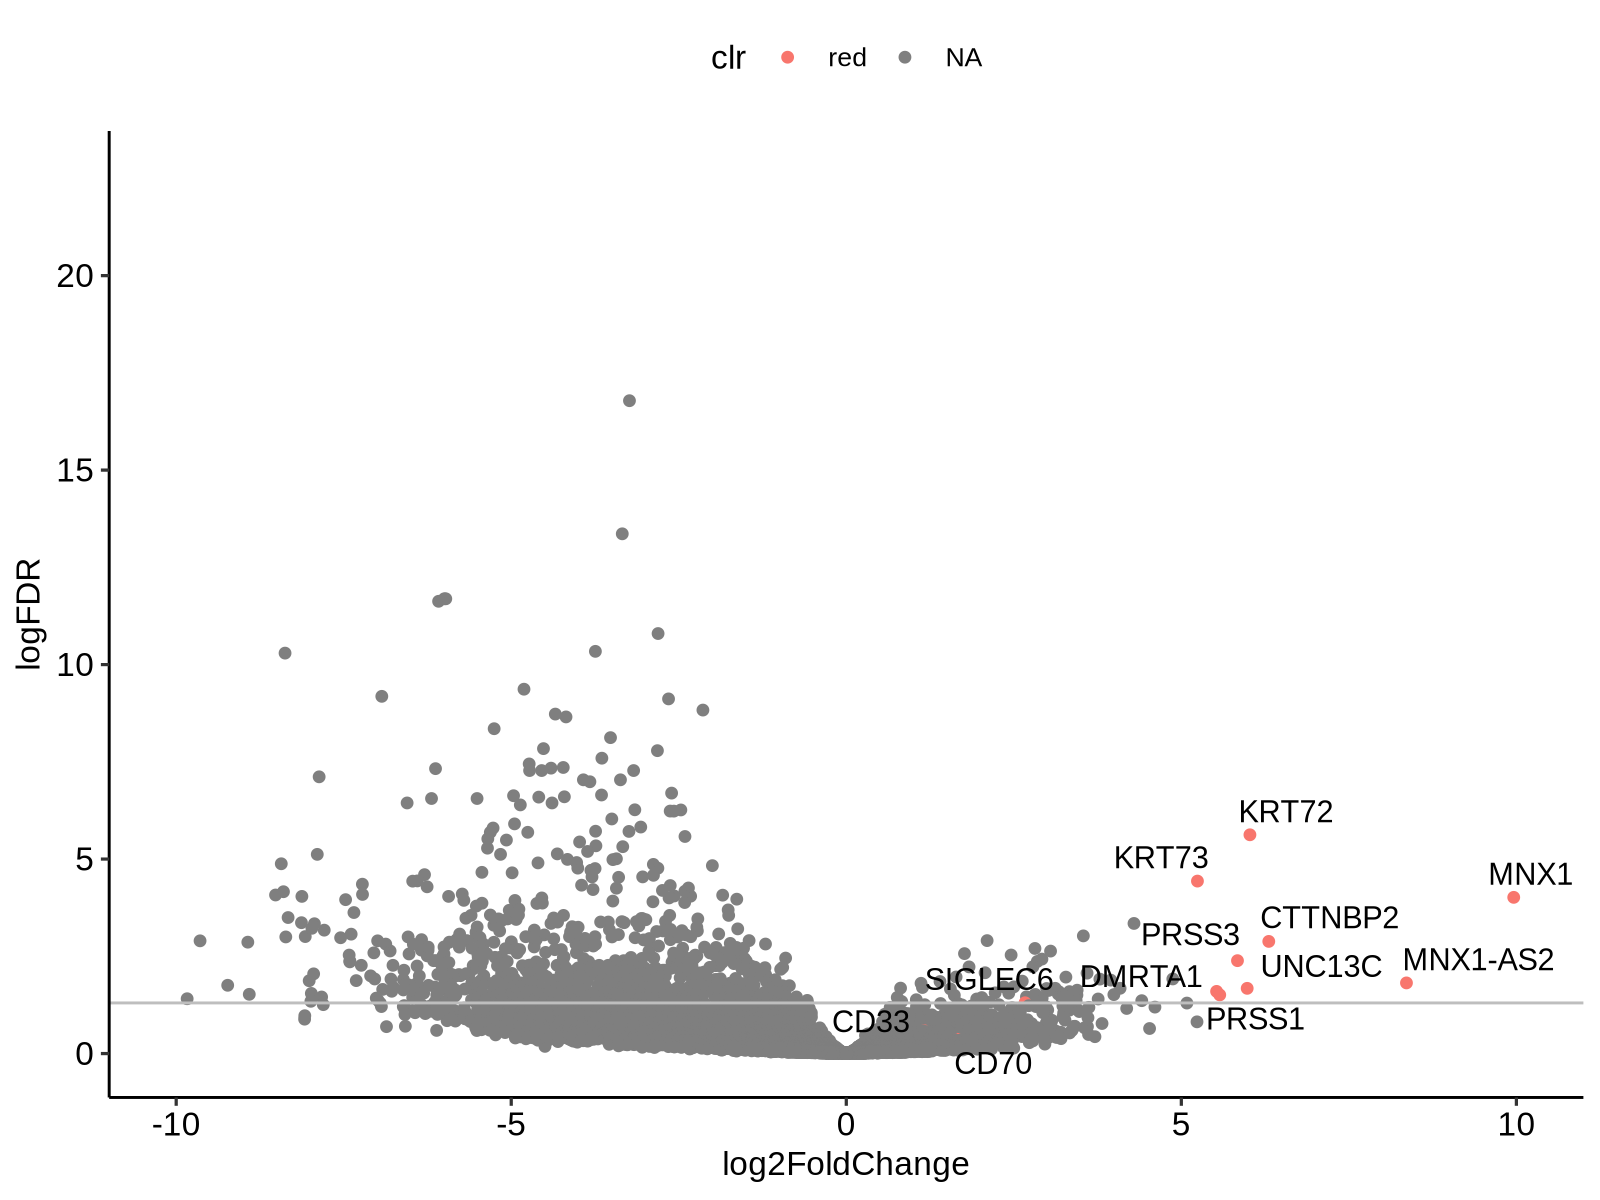

In [268]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = copy(res)
plotdat[log2FoldChange < -10, lbl := rn]
plotdat[log2FoldChange > 5 & padj < 0.05, lbl := rn]
plotdat[rn %in% gene_sel, lbl := rn]
plotdat[!is.na(lbl), clr := 'red'] 
plotdat[, logFDR := -log(padj, 10)] 
ggplot(plotdat, aes(log2FoldChange, logFDR, label = lbl)) + geom_point(aes(color = clr)) + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel() + xlim(-10, 10)


Warning message:
"Removed 5193 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 27676 rows containing missing values (`geom_text_repel()`)."


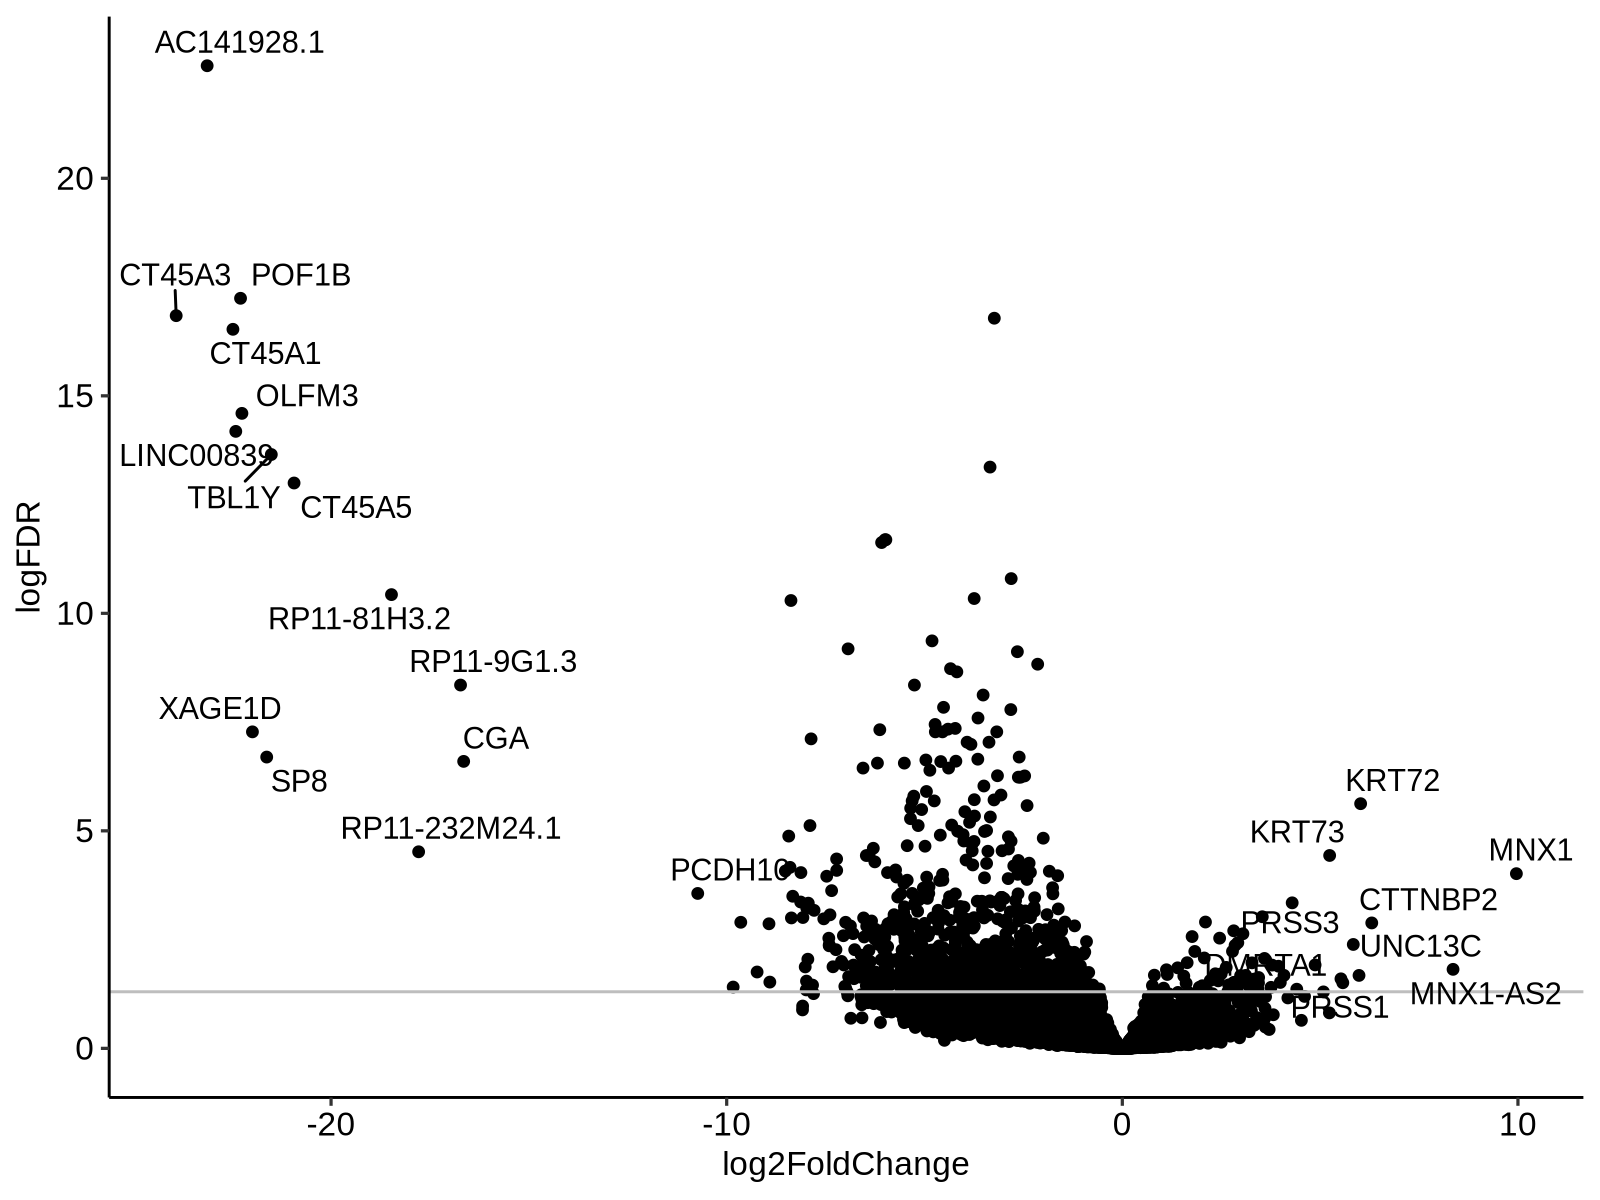

In [183]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = copy(res)
plotdat[log2FoldChange < -10, lbl := rn]
plotdat[log2FoldChange > 5 & padj < 0.05, lbl := rn]
plotdat[, logFDR := -log(padj, 10)] 
ggplot(plotdat, aes(log2FoldChange, logFDR, label = lbl)) + geom_point() + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel()


Warning message:
"Removed 5208 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 27691 rows containing missing values (`geom_text_repel()`)."


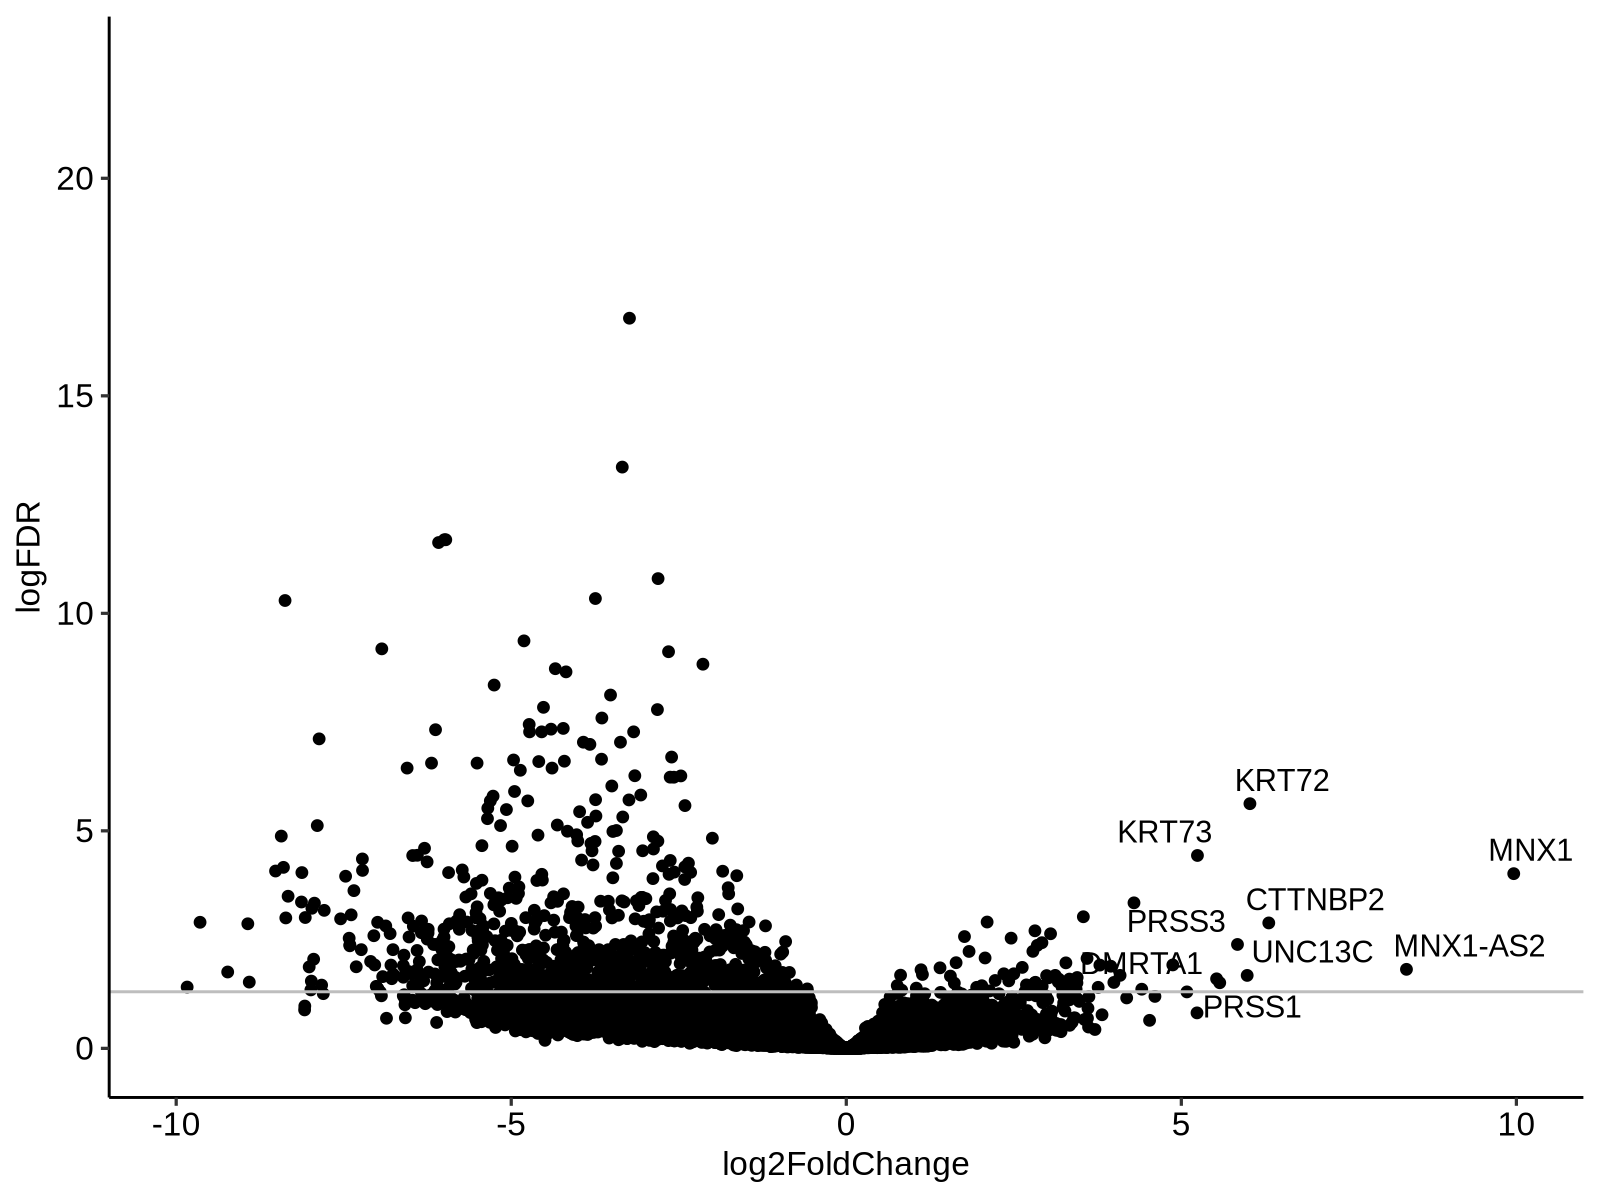

In [187]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
ggplot(plotdat, aes(log2FoldChange, logFDR, label = lbl)) + geom_point() + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel() + xlim(-10, 10)


In [62]:
res[rn == 'MNX1', ]

rn   baseMean log2FoldChange lfcSE    stat      pvalue       padj        
1 MNX1 50.65322 -9.96038       1.983748 -5.020991 5.140555e-07 9.641539e-05

## vs pAML pathway analysis


In [228]:
length(pathways)


[1] 50

In [229]:
res[, ranking := -log2FoldChange*log10(pvalue)]
tmp = res[!is.na(ranking), ] 
ranking = tmp$ranking
names(ranking) = tmp$rn
head(ranking)


AC141928.1      POF1B     CT45A3     INPPL1     CT45A1      OLFM3 
-623.17458 -474.58710 -495.45733  -66.44383 -453.70644 -404.36258

In [236]:
ranking['MNX1']

MNX1 
62.64118

In [ ]:
pathwaysDF <- msigdbr(species = "Homo sapiens", category="C7", subcategory = 'IMMUNESIGDB') 
#pathwaysDF <- msigdbr(species = "Homo sapiens", category="C2", subcategory = 'CP:REACTOME') 
#pathwaysDF <- msigdbr(species = "Homo sapiens", category="H")
pathways <- split(as.character(pathwaysDF$gene_symbol), pathwaysDF$gs_name)
pathways[1]

fgseaRes <- fgsea(pathways = pathways, stats = ranking, eps = 0.0, minSize = 15, maxSize = 500)
fgseaRes[, logFDR := -log2(pval)] 
fgseaRes[NES > 0, updn := 'UP']
fgseaRes[NES < 0, updn := 'DN']
fgseaRes = fgseaRes [order(pval), ]
head(fgseaRes)


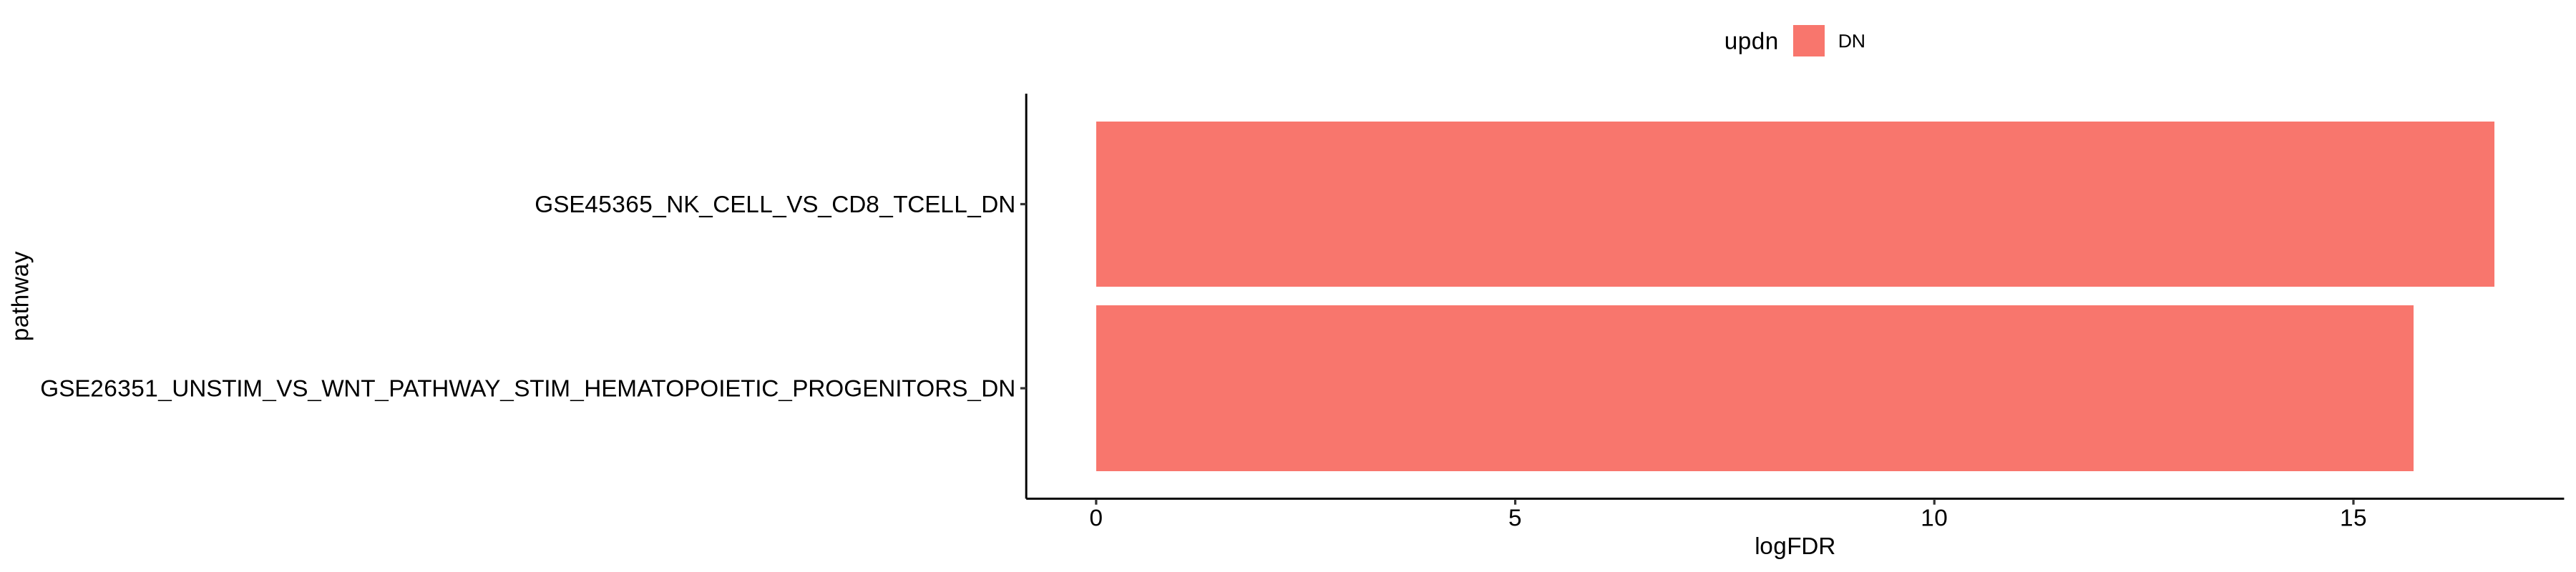

In [313]:
options(repr.plot.width = 18, repr.plot.height = 4, repr.plot.res = 200)
plotdat = fgseaRes[order(pval), ][padj < 0.05, ]
ggplot(plotdat, aes(pathway, logFDR, fill = updn)) + geom_bar(stat = 'identity') + coord_flip() + theme_pubr()



In [235]:
plotdat
head(fgseaRes)

pathway pval padj log2err ES NES size leadingEdge logFDR updn

pathway                      pval       padj      log2err    ES        
1 HALLMARK_ADIPOGENESIS        0.32867133 1.0000000 0.06523531 -0.6169231
2 HALLMARK_ALLOGRAFT_REJECTION 1.00000000 1.0000000 0.00000000 -0.3741160
3 HALLMARK_ANDROGEN_RESPONSE   0.85300000 1.0000000 0.01900420 -0.5284535
4 HALLMARK_ANGIOGENESIS        0.82153846 1.0000000 0.02279818 -0.5248469
5 HALLMARK_APICAL_JUNCTION     0.63536464 1.0000000 0.03456643 -0.5762577
6 HALLMARK_APICAL_SURFACE      0.03959391 0.9494505 0.22798720 -0.7750545
  NES        size leadingEdge  logFDR    updn
1 -1.0332550 186  RAB34, M.... 1.6052825 DN  
2 -0.6266960 185  TLR2, CD.... 0.0000000 DN  
3 -0.8819524  95  BMPR1B, .... 0.2293824 DN  
4 -0.8486218  34  POSTN, V.... 0.2836000 DN  
5 -0.9646836 189  INPPL1, .... 0.6543433 DN  
6 -1.2677844  42  ATP6V0A4.... 4.6585777 DN

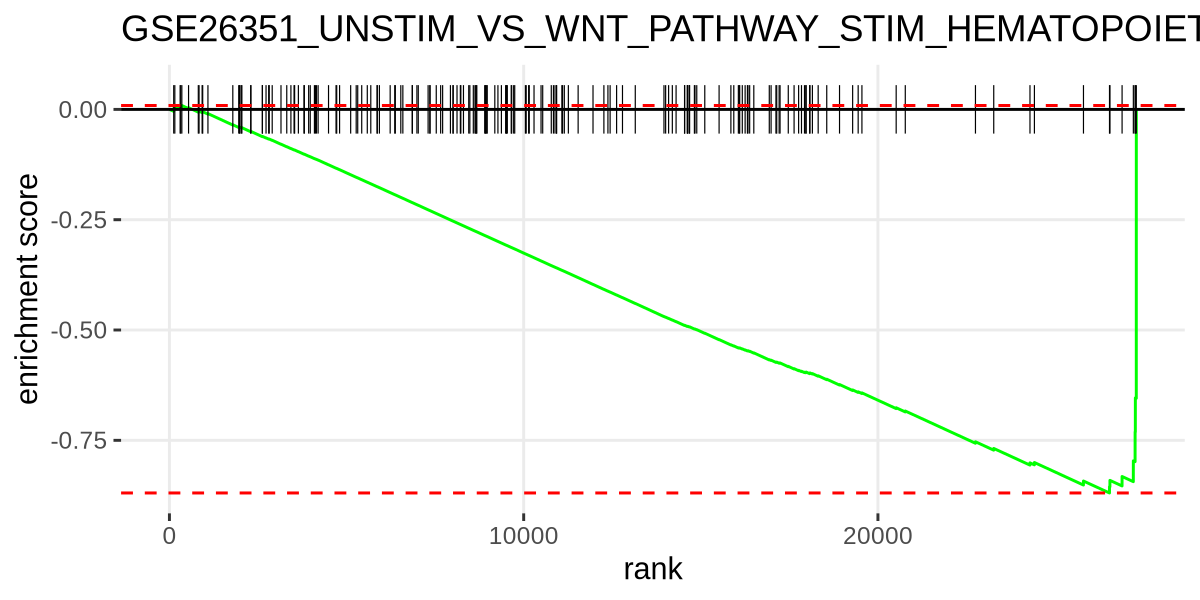

In [112]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 200)
plotEnrichment(pathways[["GSE26351_UNSTIM_VS_WNT_PATHWAY_STIM_HEMATOPOIETIC_PROGENITORS_DN"]], ranking) + 
labs(title="GSE26351_UNSTIM_VS_WNT_PATHWAY_STIM_HEMATOPOIETIC_PROGENITORS_DN")


## vs pAML heatmap of top genes


In [188]:
res_sig = res[abs(log2FoldChange) > 1 & padj < 0.05, ]
mtx_norm_counts = counts(dds, normalized = T)
mtx_norm_counts = mtx_norm_counts[res_sig$rn, ]
head(mtx_norm_counts)
dim(mtx_norm_counts)


SJCBF022_D   SJCBF030_D   SJCBF034_D   SJAML007110_D1 SJAML007122_D1
AC141928.1    1.4410362  139.8705376 1.364310e+02  230.3089387      0.0000000  
POF1B         0.3602591    0.6644681 7.105781e-01    0.4218112      0.6316016  
CT45A3        0.3602591    0.0000000 0.000000e+00    0.0000000      0.0000000  
INPPL1     9092.2181060 9221.1562241 1.729902e+04 3568.5231169   7306.3677648  
CT45A1        0.7205181    0.0000000 0.000000e+00    0.0000000      0.0000000  
OLFM3         0.7205181    0.3322341 0.000000e+00    0.0000000      0.0000000  
           SJAML030118_D1 SJAML030324_D1 SJAML045742_D2 SJAML031259_D1
AC141928.1    0.000          5.937306       0.0000000     28.9359     
POF1B         0.000          0.000000       0.9705287      0.0000     
CT45A3     2103.299          0.000000     482.3527790      0.0000     
INPPL1     6879.298       5898.713527    7747.7308553   5876.7445     
CT45A1     1822.084          0.000000     524.0855145      0.0000     
OLFM3         0.000          0.000000       0.0000000      0.0000     
           SJAML031302_D2 ⋯ SJAML040685_D1 SJAML040686_D1 SJAML040687_D1
AC141928.1    2.244205    ⋯   0.000000       0.0000         0.0000      
POF1B         2.244205    ⋯   1.491916       0.0000         0.0000      
CT45A3        0.000000    ⋯   0.000000       0.0000         0.0000      
INPPL1     5570.116453    ⋯ 963.280172     625.0739       749.9207      
CT45A1        0.000000    ⋯   0.000000       0.0000         0.0000      
OLFM3         0.000000    ⋯   0.000000       0.0000         0.0000      
           SJAML040689_D1 SJAML040690_D1 SJAML040692_D1 SJAML040693_D1
AC141928.1   0.000000        1.183327      2.199715       0.00000     
POF1B        5.502672        0.000000     19.797436       2.68583     
CT45A3       0.000000     1804.573534      0.000000       0.00000     
INPPL1     483.318013     2122.888472    777.965907     261.42079     
CT45A1       0.000000     1815.223476      0.000000       0.00000     
OLFM3        0.000000        0.000000      0.000000       0.00000     
           SJAML040694_D1 SJAML040695_D1 SJAML040710_D3
AC141928.1   0.00000        0.0000000      0.0000      
POF1B       83.62363        0.0000000      0.0000      
CT45A3       0.00000        0.4429579      0.0000      
INPPL1     856.18324      875.7277444    728.0657      
CT45A1       0.00000        0.4429579      0.0000      
OLFM3      102.03617        0.0000000      0.0000

[1] 939 887

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



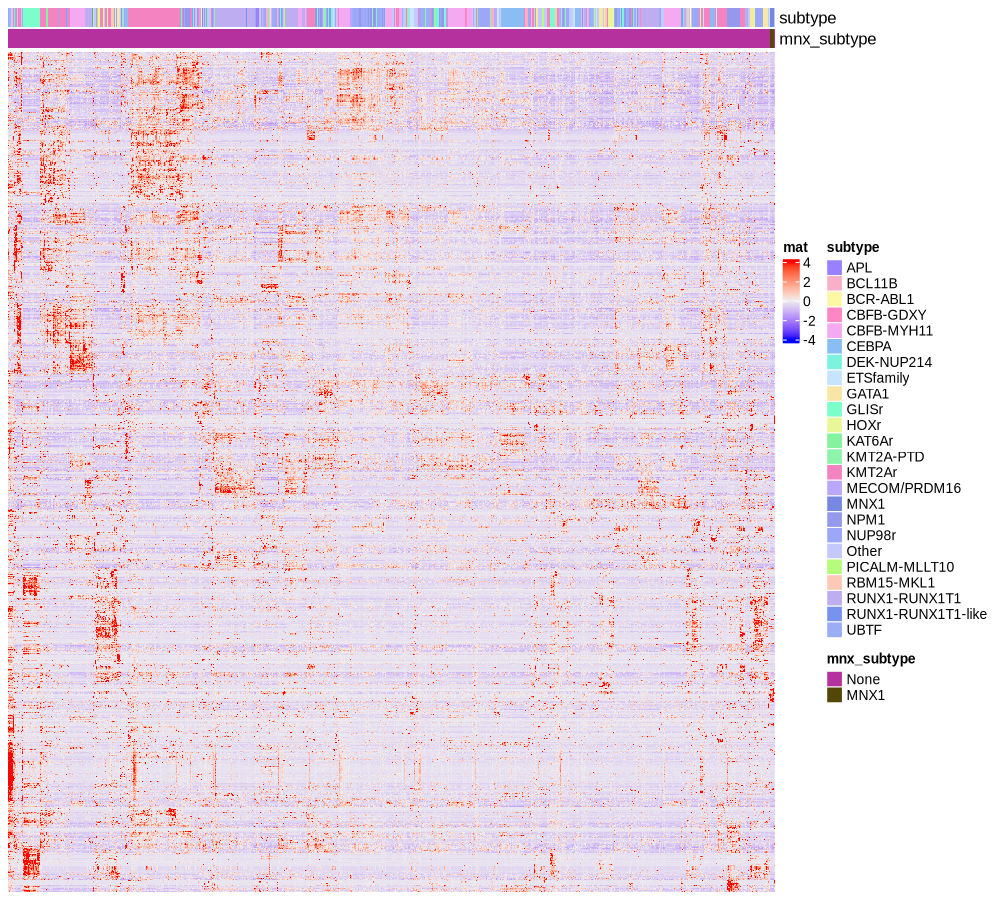

In [189]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 100)
column_ha = HeatmapAnnotation(df = mtx_clin_exp_df[, c('subtype', 'mnx_subtype')])
platdat = scale_fun(mtx_norm_counts)
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2
Heatmap(platdat, name = "mat", top_annotation = column_ha, show_column_names = F, show_row_names = F, show_column_dend = F, 
       show_row_dend = F) 


# vs pAML w/ paired condition

In [201]:
mtx_clin_exp_df$subtype3 =gsub('-', '.', mtx_clin_exp_df$subtype)
mtx_clin_exp_df$subtype3 =gsub('/', '.', mtx_clin_exp_df$subtype3)
lvls = sort(unique(mtx_clin_exp_df$subtype3) )
lvls = gsub('-', '.', lvls) 
lvls = gsub('/', '.', lvls) 
pair_dsn = data.table(t1 = character(), t2 = character(), t1_num = numeric(), t2_num = numeric(), 
                      rds_file = character(), res_file = character() )

ii = 1
jj = 2
l1 = lvls[ii]
l2 = lvls[jj]
l1_sample_name = mtx_clin_exp_df[mtx_clin_exp_df$subtype3 == l1, 'sample_name'] 
l2_sample_name = mtx_clin_exp_df[mtx_clin_exp_df$subtype3 == l2, 'sample_name'] 
m1 = mtx[, l1_sample_name]
m2 = mtx[, l2_sample_name]
mm = cbind(m1, m2)
dd = data.frame(subtype = c(rep(l1, length(l1_sample_name)), rep(l2, length(l2_sample_name))), row.names = c(l1_sample_name, l2_sample_name))

dds <- DESeqDataSetFromMatrix( countData = mm, design = ~ subtype, colData = dd)
#smallestGroupSize <- 15
#keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
#dds <- dds[keep,]
dds <- DESeq(dds, test="Wald")
fname1 = paste0('data/', l1, '_vs_', l2, '.rds')
saveRDS(dds, file = fname1)

tmp = data.frame(results(dds), keep.rownames = T) 
fname2 = paste0('data/', l1, '_vs_', l2, '.tsv')
fwrite(tmp, file = fname2, sep = '\t')

rbind(pair_dsn, list(l1, l2, length(l1), length(l2), fname1, fname2))
      

APLBCL11B



In [ ]:
library(DESeq2)
library(data.table)

dds = readRDS('data/nb_clin_pAML_dds_paired.rds')
mtx_clin_exp_df = readRDS('data/mtx_clin_exp_df.rds')
mtx_clin_exp_df$subtype3 =gsub('-', '.', mtx_clin_exp_df$subtype)
mtx_clin_exp_df$subtype3 =gsub('/', '.', mtx_clin_exp_df$subtype3)
lvls = sort(unique(mtx_clin_exp_df$subtype3))
lvls = gsub('-', '.', lvls) 
lvls = gsub('/', '.', lvls) 

res_list = list()

for( ii in 1:(length(lvls) - 1) ){
#    for( jj in (ii + 1) : length(lvls) ){
    for(jj in (ii + 1) : 3){
        l1 = lvls[ii]
        l2 = lvls[jj]
        l1_sample_name = mtx_clin_exp_df[mtx_clin_exp_df$subtyp3 == l1, 'sample_name'] 
        l2_sample_name = mtx_clin_exp_df[mtx_clin_exp_df$subtyp3 == l2, 'sample_name'] 
        m1 = mtx[, l1_sample_name]
        m2 = mtx[, l2_sample_name]
        mm = cbind(m1, m2)
        #dd = data.frame(subtype = c(rep(l1, length(l1_sample_name)), rep(l2, length(l2_sample_name))), row.names = c(l1_sample_name, l2_sample_name))
        tmp = as.data.table(results(dds, contrast = c('subtype', l1, l2)), keep.rownames = T)
        tmp = tmp[order(padj), ][padj < 0.1, ]
        res_list[[paste(l1, '_', l2)]] = tmp
        #saveRDS(tmp, file = paste0(l1, '_', l2, '.rds'))
     }
}

saveRDS(res_list, file = 'data/res_list.rds')


In [ ]:
dds <- DESeqDataSetFromMatrix(
    countData = mtx_exp,
    design = ~ subtype,
    colData = mtx_clin_exp_df)
smallestGroupSize <- 15
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]
dds <- DESeq(dds, test="Wald")
saveRDS(dds, file = 'data/nb_clin_pAML_dds_paired.rds')


In [152]:
cmps = resultsNames(dds)
length(cmps)
head(cmps)


[1] 24

[1] "Intercept"                 "subtype_BCL11B_vs_APL"    
[3] "subtype_BCR.ABL1_vs_APL"   "subtype_CBFB.GDXY_vs_APL" 
[5] "subtype_CBFB.MYH11_vs_APL" "subtype_CEBPA_vs_APL"

In [178]:
saveRDS(mtx_clin_exp_df, file = 'data/mtx_clin_exp_df.rds') 


In [176]:
lvls = unique(mtx_clin_exp_df$subtype)
lvls = gsub('-', '.', lvls)
lvls = gsub('/', '.', lvls)
lvls


[1] "CBFB.MYH11"         "RUNX1.RUNX1T1"      "KMT2Ar"            
 [4] "NPM1"               "RUNX1.RUNX1T1.like" "UBTF"              
 [7] "GATA1"              "Other"              "HOXr"              
[10] "GLISr"              "NUP98r"             "KAT6Ar"            
[13] "RBM15.MKL1"         "MNX1"               "BCR.ABL1"          
[16] "CEBPA"              "DEK.NUP214"         "KMT2A.PTD"         
[19] "ETSfamily"          "CBFB.GDXY"          "MECOM.PRDM16"      
[22] "APL"                "PICALM.MLLT10"      "BCL11B"

In [177]:
resultsNames(dds)

[1] "Intercept"                         "subtype_BCL11B_vs_APL"            
 [3] "subtype_BCR.ABL1_vs_APL"           "subtype_CBFB.GDXY_vs_APL"         
 [5] "subtype_CBFB.MYH11_vs_APL"         "subtype_CEBPA_vs_APL"             
 [7] "subtype_DEK.NUP214_vs_APL"         "subtype_ETSfamily_vs_APL"         
 [9] "subtype_GATA1_vs_APL"              "subtype_GLISr_vs_APL"             
[11] "subtype_HOXr_vs_APL"               "subtype_KAT6Ar_vs_APL"            
[13] "subtype_KMT2A.PTD_vs_APL"          "subtype_KMT2Ar_vs_APL"            
[15] "subtype_MECOM.PRDM16_vs_APL"       "subtype_MNX1_vs_APL"              
[17] "subtype_NPM1_vs_APL"               "subtype_NUP98r_vs_APL"            
[19] "subtype_Other_vs_APL"              "subtype_PICALM.MLLT10_vs_APL"     
[21] "subtype_RBM15.MKL1_vs_APL"         "subtype_RUNX1.RUNX1T1_vs_APL"     
[23] "subtype_RUNX1.RUNX1T1.like_vs_APL" "subtype_UBTF_vs_APL"

In [175]:
res_list = list()
for( ii in 1:(length(lvls) - 1) ){
    for( jj in (ii + 1) : length(lvls) ){
        l1 = lvls[ii]
        l2 = lvls[jj]
        tmp = as.data.table(results(dds, contrast = c('subtype', l1, l2)), keep.rownames = T) 
        tmp = tmp[order(padj), ]
        res_list[[paste(l1, '_', l2)]] = tmp 
     }
}

Warning message in .local(x, row.names, optional, ...):
"Arguments in '...' ignored"


In [179]:
res_sig_list = lapply(res_list, function(xx){
    xx[abs(log2FoldChange) > 1 & padj < 0.05, rn]
})


In [180]:
length(res_sig_list[[1]])

[1] 4484

In [181]:
lapply(res_sig_list, length)

$`CBFB.MYH11 _ RUNX1.RUNX1T1`
[1] 4484

In [160]:
results(dds, contrast = c('subtype', 'BCL11B', 'APL')) 

log2 fold change (MLE): subtype BCL11B vs APL 
Wald test p-value: subtype BCL11B vs APL 
DataFrame with 27700 rows and 6 columns
              baseMean log2FoldChange     lfcSE       stat    pvalue      padj
             <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
7SK            1.77233      0.8641841  2.337784  0.3696595  0.711636  0.876869
A1BG          29.66764      1.1216591  0.716604  1.5652428  0.117526  0.326033
A1BG-AS1     177.54127     -0.1235262  0.695405 -0.1776320  0.859012  0.951243
A1CF           3.39813      0.0549957  2.581557  0.0213033  0.983004  0.995659
A2M          153.76147     -0.9737566  1.216659 -0.8003528  0.423506  0.678370
...                ...            ...       ...        ...       ...       ...
hsa-mir-490    7.94591       2.457192  2.479913  0.9908382  0.321765  0.585437
hsa-mir-6080 278.34638       0.322933  0.441891  0.7307976  0.464903  0.713368
hsa-mir-7515   3.86836      -0.782599  2.860801 -0.2735595  0.784423  0.914844
hs

In [149]:
1:3

[1] 1 2 3

# vs CD34

## vs CD34 DEG

In [61]:
mtx_clin_mnx = mtx_clin[grep('MNX', subtype), ]
mtx_clin_mnx_cd34 = data.frame(subtype = c(rep('MNX1', nrow(mtx_clin_mnx)), rep('CD34', ncol(mtx_cd34))))
rownames(mtx_clin_mnx_cd34) = c(mtx_clin_mnx$sample_name, colnames(mtx_cd34))
mtx_clin_mnx_cd34$subtype = factor(mtx_clin_mnx_cd34$subtype, levels = c('CD34', 'MNX1'))
mtx_clin_mnx_cd34


subtype
SJAML040604_D1   MNX1   
SJAML040634_D1   MNX1   
SJAML044827_D1   MNX1   
SJAML060291_D1   MNX1   
SJAMLM7010950_D1 MNX1   
SJAML062379_G1   CD34   
SJAML062380_G1   CD34   
SJAML062381_G1   CD34   
SJAML062382_G1   CD34   
SJAML062383_G1   CD34

In [62]:
mtx_mtx_cd34 = cbind(mtx[, mtx_clin_mnx$sample_name], mtx_cd34)
mtx_mtx_cd34[1:3,] 


SJAML040604_D1 SJAML040634_D1 SJAML044827_D1 SJAML060291_D1
5S_rRNA 0              0              0               0            
7SK     0              0              1               0            
A1BG    0              6              1              20            
        SJAMLM7010950_D1 SJAML062379_G1 SJAML062380_G1 SJAML062381_G1
5S_rRNA 0                13             10             10            
7SK     0                 6              6              4            
A1BG    5                54             36             32            
        SJAML062382_G1 SJAML062383_G1
5S_rRNA 17              13           
7SK      8               9           
A1BG    27             101

In [63]:
dds_mnx_cd34 <- DESeqDataSetFromMatrix(
    countData = mtx_mtx_cd34,
    design = ~ subtype,
    colData = mtx_clin_mnx_cd34)


In [64]:
smallestGroupSize <- 15
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds_mnx_cd34 <- dds_mnx_cd34[keep,]
dds_mnx_cd34 <- DESeq(dds_mnx_cd34, test="Wald")


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [65]:
saveRDS(dds_mnx_cd34, file = 'data/nb_clin_AML_mar22_dds_mnx_cd34.rds')
#dds_mnx_cd34 = readRDS(file = 'data/nb_clin_AML_mar22_dds_mnx_cd34.rds')


In [71]:
res_mnx_cd34 = results(dds_mnx_cd34)
res_mnx_cd34 = as.data.table(res_mnx_cd34, keep.rownames = T) 
res_mnx_cd34 = res_mnx_cd34[order(padj), ]
head(res_mnx_cd34)


Warning message in .local(x, row.names, optional, ...):
"Arguments in '...' ignored"


rn       baseMean  log2FoldChange lfcSE     stat      pvalue      
1 NUDT11    449.9963 -7.964949      0.4452365 -17.88925 1.430079e-71
2 SLC25A27  493.9021 -7.939447      0.4630760 -17.14502 6.847627e-66
3 MNX1     5365.2271  9.333534      0.5609205  16.63967 3.595663e-62
4 PLAG1    1185.0571 -3.949067      0.2400303 -16.45237 8.065051e-61
5 EDIL3    1979.8325  7.718970      0.4743186  16.27381 1.514392e-59
6 SMARCA1   471.2492 -6.564263      0.4072420 -16.11883 1.881489e-58
  padj        
1 4.641894e-67
2 1.111336e-61
3 3.890388e-58
4 6.544587e-57
5 9.831128e-56
6 1.017854e-54

In [68]:
fwrite(res_mnx_cd34, file = 'data/DEG_MNX1_vs_CD34.xls', sep = '\t')


## overlap targets between vs pAML and vs CD34


In [92]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
res_sig_genes = res[log2FoldChange > 2 & padj < 0.05, rn]
res_mnx_cd34_sig_genes = res_mnx_cd34[log2FoldChange > 2 & padj < 0.05, rn]
length(res_mnx_cd34_sig_genes) # 1013
length(res_sig_genes) # 54
length(intersect(res_sig_genes, res_mnx_cd34_sig_genes)) # 33
ov_list = list(vs_pAML = res_sig_genes, vs_CD34 = res_mnx_cd34_sig_genes)
 

[1] 1013

[1] 54

[1] 33

[1] 1

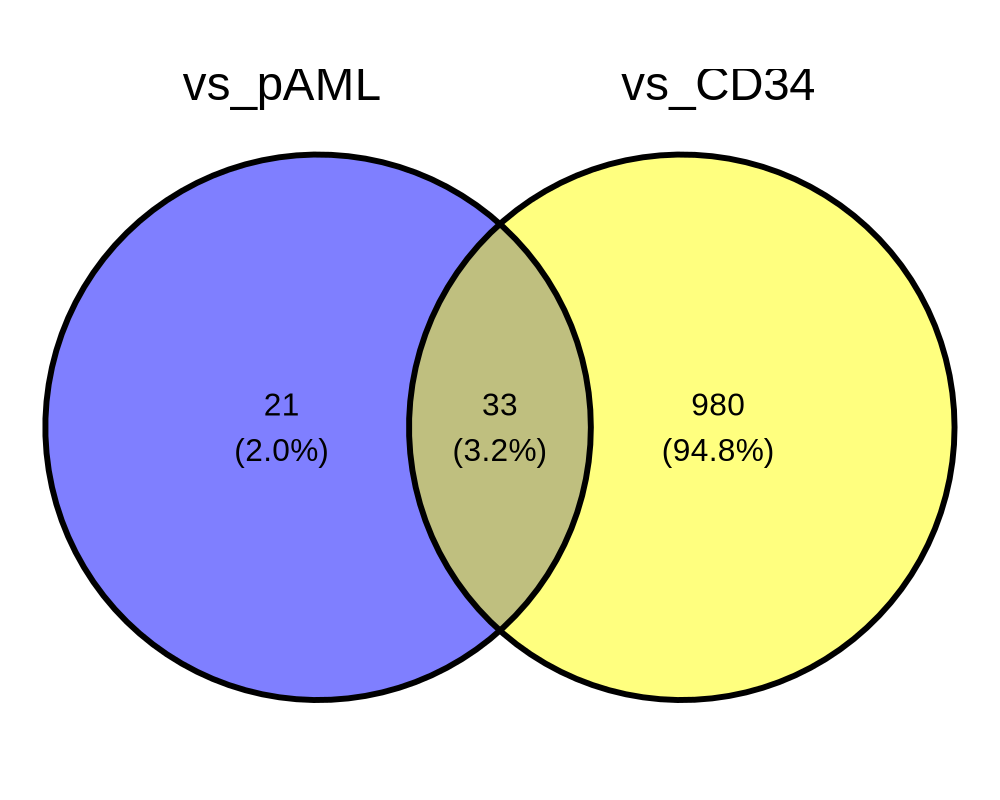

In [101]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)
#draw.pairwise.venn(area1=980, area2=33,cross.area=21,  category=c("vspAML","vsCD34"),fill=c("Blue","Green"))
ggvenn(ov_list)


## vs CD34 MAPplot

Warning message:
"Removed 1113 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 33519 rows containing missing values (`geom_text_repel()`)."
Warning message:
"ggrepel: 36 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


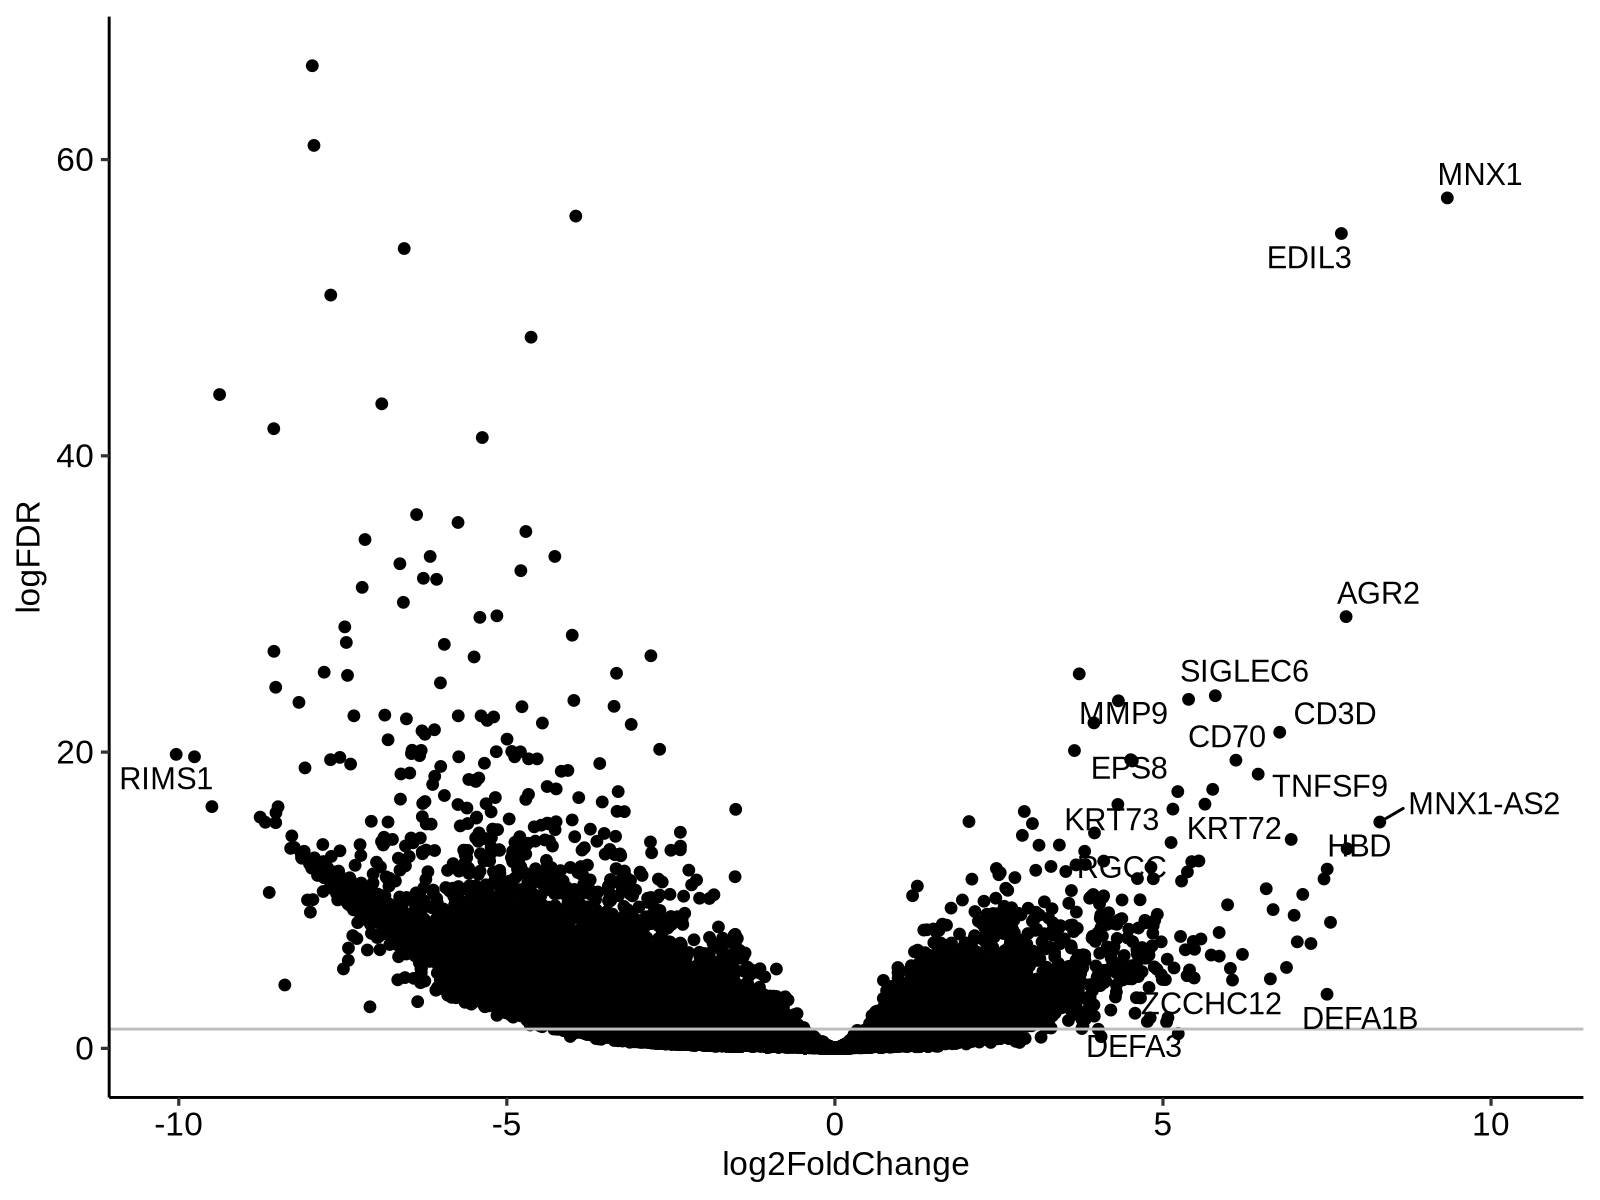

In [72]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 200)
plotdat = copy(res_mnx_cd34)
plotdat[log2FoldChange < -10, lbl := rn]
plotdat[log2FoldChange > 5 & padj < 0.05, lbl := rn]
plotdat[, logFDR := -log(padj, 10)] 
ggplot(plotdat, aes(log2FoldChange, logFDR, label = lbl)) + geom_point() + theme_pubr() +
geom_hline(yintercept = -log(0.05, 10), color = 'grey') + geom_text_repel()


## vs CD34 pathways

In [118]:
res_mnx_cd34[, ranking := -log2FoldChange*log10(pvalue)]
tmp = res_mnx_cd34[!is.na(ranking), ] 
ranking_vsCD34 = tmp$ranking
names(ranking_vsCD34) = tmp$rn
head(ranking_vsCD34)


NUDT11  SLC25A27      MNX1     PLAG1     EDIL3   SMARCA1 
-564.2739 -517.3698  573.4917 -237.3128  454.0280 -378.9253

In [119]:
fgsea_vsCD34 <- fgsea(pathways = pathways, stats = ranking_vsCD34, eps = 0.0, minSize = 15, maxSize = 500)


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (2.34% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"There were 1955 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)"


In [120]:
fgseaRes = as.data.table(fgseaRes)
fgseaRes = fgseaRes[order(padj), ]
head(fgseaRes)

pathway                                                          pval        
1 GSE26351_UNSTIM_VS_WNT_PATHWAY_STIM_HEMATOPOIETIC_PROGENITORS_DN 7.016515e-06
2 GSE45365_NK_CELL_VS_CD8_TCELL_DN                                 1.996650e-05
3 GSE17721_CPG_VS_GARDIQUIMOD_2H_BMDC_DN                           4.032879e-04
4 GSE17721_POLYIC_VS_PAM3CSK4_8H_BMDC_DN                           7.372888e-04
5 GSE20715_WT_VS_TLR4_KO_48H_OZONE_LUNG_DN                         5.999077e-04
6 GSE32034_LY6C_HIGH_VS_LOW_MONOCYTE_DN                            6.457014e-04
  padj       log2err   ES         NES       size leadingEdge 
1 0.03377750 0.6105269 -0.8692912 -1.454555 185  POF1B, P....
2 0.04805936 0.5756103 -0.8820274 -1.481365 154  POF1B, L....
3 0.44366352 0.4984931 -0.8266459 -1.384052 194  POF1B, L....
4 0.44366352 0.4772708 -0.8230509 -1.377321 187  OLFM3, T....
5 0.44366352 0.4772708 -0.8297181 -1.388772 178  POF1B, G....
6 0.44366352 0.4772708 -0.8272628 -1.384623 190  OLFM3, H....